In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ast
import numpy as np
# plt.style.use('tableau-colorblind10')
from matplotlib.lines import Line2D 

# colors = ['#F0E442', '#D55E00', '#009E73', '#4D4D4D', '#56B4E9']  # Blue, Orange, Green, Yellow, Light Blue
colors_blind=[ '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1',  '#FFBC79',  
              '#006BA4','#CFCFCF','#C85200','#898989', '#A2C8EC',]


/home/simrank/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from CODES import base_other_codes as bc
def path_results_old_results(ds,network,corrupt,run):
    if network=='MLP':
        net_corr=f'../../pca_angle/angle_results/{ds}_{network}/SGD/results_{corrupt}/angle_results/Run{run}/cor_label'
    elif network=='CNN':
        net_corr=f'../../pca_angle/angle_results/{ds}_{network}/SUBSPACE/results_{corrupt}/angle_results/Run_{run}/cor_label'
    elif network=='AlexNet'and ds=='TinyImageNet':
        net_corr=f'../../pca_angle/angle_results/{ds}_{network}/results/results_{corrupt}/angle_results/Run_{run}/cor_label'
    elif network=='AlexNet'and ds=='CIFAR100':
        net_corr=f'../../pca_angle/angle_results/{ds}_{network}/results_{corrupt}/angle_results/Run_{run}/cor_label'
        
    return net_corr

In [3]:
class plotting_base:
    def __init__(self):
        self.x_fontsize_label=25
        self.y_fontsize_label=25
        self.x_fontsize=20
        self.y_fontsize=20
        self.t_fontsize=20
        self.size_prop=18

        self.row=5
        self.col=3


        self.figure_size=(18,25)
        # figure_size=(10,12)
        self.rotation=30
        self.w_space=0.00001
        self.h_space=None
        self.markersize=5
        self.title_font=18
        self.label_text='% corruption degree'
        self.x_label='Network layers'
        self.pad_value=10
        self.corruptions=[0.0,0.2,0.4,0.6,0.8]
        self.exp1='cor_label'
        self.mapping = {0.0:0,0.2:20, 0.4:40,0.6:60,0.8:80,1.0:100}
        self.mapping2 = {'MNIST':'MNIST','FashionMNIST':'Fashion-MNIST','CIFAR10':'CIFAR-10',
                'CIFAR100':'CIFAR-100','TinyImageNet':'Tiny ImageNet'}
        self.folders = {'Logistic regression':'logistic_regression',
                 'NCM':'nearest_class_mean' ,'LDA':'LDA',
                 'QDA':'QDA','k-NN':'KNN'}
    def get_corrupt(self,val):
        return self.mapping.get(val, val)

    def get_dataname(self,val):
        return self.mapping2.get(val, val)
    def get_folder_name(self,val):
        return self.folders.get(val, val)
    
    def path_results(self,dataset,type_network,corrupt,subspace,probe):
        basefolder=f'../stronger_baselines/results/{probe}/{dataset}_{type_network}/results_{corrupt}'
        if subspace=='corrupt':
            file_path=f'{basefolder}/angle_results'
        if subspace=='original':
            file_path=f'{basefolder}/angle_results_exp3'
        return file_path
    def path_acc(self,dataset,type_network,corrupt):
        accu_path=f'../model_accuracy/{dataset}_{type_network}/{corrupt}'
        return accu_path
    def path_masc(self,dataset,type_network,corrupt,subspace):
        seed_value=10
        basefolder=f'../sensitivity_ablation_studies/results/{seed_value}/angle_results_0.99'
        basefolder=f'{basefolder}/{dataset}_{type_network}/results_{corrupt}'
        if subspace=='corrupt':
            file_path=f'{basefolder}/angle_results'
        if subspace=='original':
            file_path=f'{basefolder}/angle_results_exp3'
            
        return file_path

    
    
    def fun_1(self,train_overall,classnumber=99):
        if classnumber==99:
            max_value = list(map(max, zip(train_overall[0], train_overall[1],train_overall[2])))
            min_value = list(map(min, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = list(map(sum, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = [x/3 for x in avg_value]
        else:
            max_value = list(map(max, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            min_value = list(map(min, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = list(map(sum, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = [x/3 for x in avg_value]
        return max_value,min_value,avg_value
    def layernames(self,network_type,ds):

        if network_type=='MLP':
            x=[0,1,2,3]
            layers=['FC (128)','FC (512)','FC (2048)','FC (2048)']#'Input',
        if network_type=='CNN':
            if  ds == 'CIFAR10':
                layers=['Flat (1024)','FC (250)','FC (250)','FC (250)']#'Input',
            if  ds != 'CIFAR10':
                layers=['Flat (576)','FC (250)','FC (250)','FC (250)']#'Input',
            x=[0,1,2,3]
        if network_type=='AlexNet':
            x=[0,1,2]
            layers=['Flat (256)','FC (4096)','FC (4096)']
        return x,layers
        
class plot_accuracy(plotting_base):    
    def model_accuracy(self,ds,type_network,corrupt):
        accuracy_path=self.path_acc(ds,type_network,corrupt)

        runs=4
        test_model=[]
        for run in range(1,runs):
            
            if type_network=='MLP':
                file_name=f'{accuracy_path}/Run{run}_Accuracy.csv'
                row_num=-2
                test_model.append(pd.read_csv(f'{file_name}')['Test_accuracy'].tolist()[row_num])
            else:
                file_name=f'{accuracy_path}/Run_{run}.csv'
                row_num=-1
                test_model.append(pd.read_csv(f'{file_name}')['Test_accuracy'].tolist()[row_num]/100)

        if type_network in ['MLP','CNN']:
            number_layer=4
        else:
            number_layer=3

        test_model=np.tile(np.array(test_model)[:, np.newaxis], number_layer)
        return test_model

    
    def acc_probe(self,type_network,ds,corrupt,file_path,probe,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        test_acc_run=[]
        for run in range(1,runs):
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1                
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            test_acc_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                if probe=='Logistic regression':
                    value=pd.read_csv(file_load)['acc_overall'][0]/100
                else:
                    value=pd.read_csv(file_load)['acc_overall'][0]
                test_acc_layer.append(value)
            test_acc_run.append(test_acc_layer)
            
        return test_acc_run
      

        
    def plot_accuracy(self,resfoldername,subspace,other):
#         colors_blind=[ '#FF800E', '#ABABAB', '#595959',
#                  '#5F9ED1',  '#FFBC79',  
#               '#006BA4','#CFCFCF','#C85200','#898989', '#A2C8EC',]
        colors_blind=[ '#006BA4', '#5F9ED1','#FF800E', '#ABABAB','#595959', '#A2C8EC','#C85200',]
        y_label='Test Accuracy'
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_other.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}.pdf'
            self.col=3
        num_cols=6
        probes=['Logistic regression','NCM','k-NN', 'LDA','QDA']#

        labels={'label0':'Model',
                'label1':f'{probes[0]} probe',
                'label2':f'{probes[1]} probe',
               'label3':f'{probes[2]} probe',
               'label4':f'{probes[3]} probe',
                'label5':f'{probes[4]} probe',
               'label6':'MASC probe'} #
        
#                         

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(self.row, self.col,count)
                test_model=self.model_accuracy(ds,type_network,corrupt)
                max_value,min_value,avg_value=self.fun_1(test_model)
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'--',markersize=self.markersize,label=labels[f'label0'],
                        color=colors_blind[0])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                color=colors_blind[0])
                for i,probe in enumerate(probes):
                    probe_folder=self.get_folder_name(probe)
                    file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                    test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe,masc=False)
                    max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'-',markersize=self.markersize,label=labels[f'label{i+1}'],
                            color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                    color=colors_blind[i+2])
                
#                 # MASC
                file_path=self.path_masc(ds,type_network,corrupt,subspace)
                test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe='MASC',masc=True)
                max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label6'],
                        color=colors_blind[1])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                color=colors_blind[1])
                
#                 if type_network!='AlexNet':
                plt.ylim(-0.01,1.01)
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
                else:
                    plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=4,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        
    def plot_accuracy_compare(self,resfoldername,subspace,other):
#         colors_blind=[ '#FF800E', '#ABABAB', '#595959',
#                  '#5F9ED1',  '#FFBC79',  
#               '#006BA4','#CFCFCF','#C85200','#898989', '#A2C8EC',]
        colors_blind=[ '#006BA4', '#5F9ED1','#FF800E', '#ABABAB','#595959', '#A2C8EC','#C85200',]
        y_label='Test Accuracy'
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_other_compare.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_compare.pdf'
            self.col=3
        num_cols=6
        probes=['Logistic regression','NCM']#

        labels={'label0':'Model',
                'label1':f'{probes[0]} probe',
                'label2':f'{probes[1]} probe',
               'label6':'MASC probe'} #
        
#                         

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(self.row, self.col,count)
                test_model=self.model_accuracy(ds,type_network,corrupt)
                max_value,min_value,avg_value=self.fun_1(test_model)
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'--',markersize=self.markersize,label=labels[f'label0'],
                        color=colors_blind[0])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                color=colors_blind[0])
                for i,probe in enumerate(probes):
                    probe_folder=self.get_folder_name(probe)
                    file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                    test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe,masc=False)
                    max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'-',markersize=self.markersize,label=labels[f'label{i+1}'],
                            color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                    color=colors_blind[i+2])
                
#                 # MASC
                file_path=self.path_masc(ds,type_network,corrupt,subspace)
                test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe='MASC',masc=True)
                max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label6'],
                        color=colors_blind[1])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                color=colors_blind[1])
                
                if type_network!='AlexNet':
                    plt.ylim(-0.01,1.01)
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
#                 else:
#                     plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=4,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
 

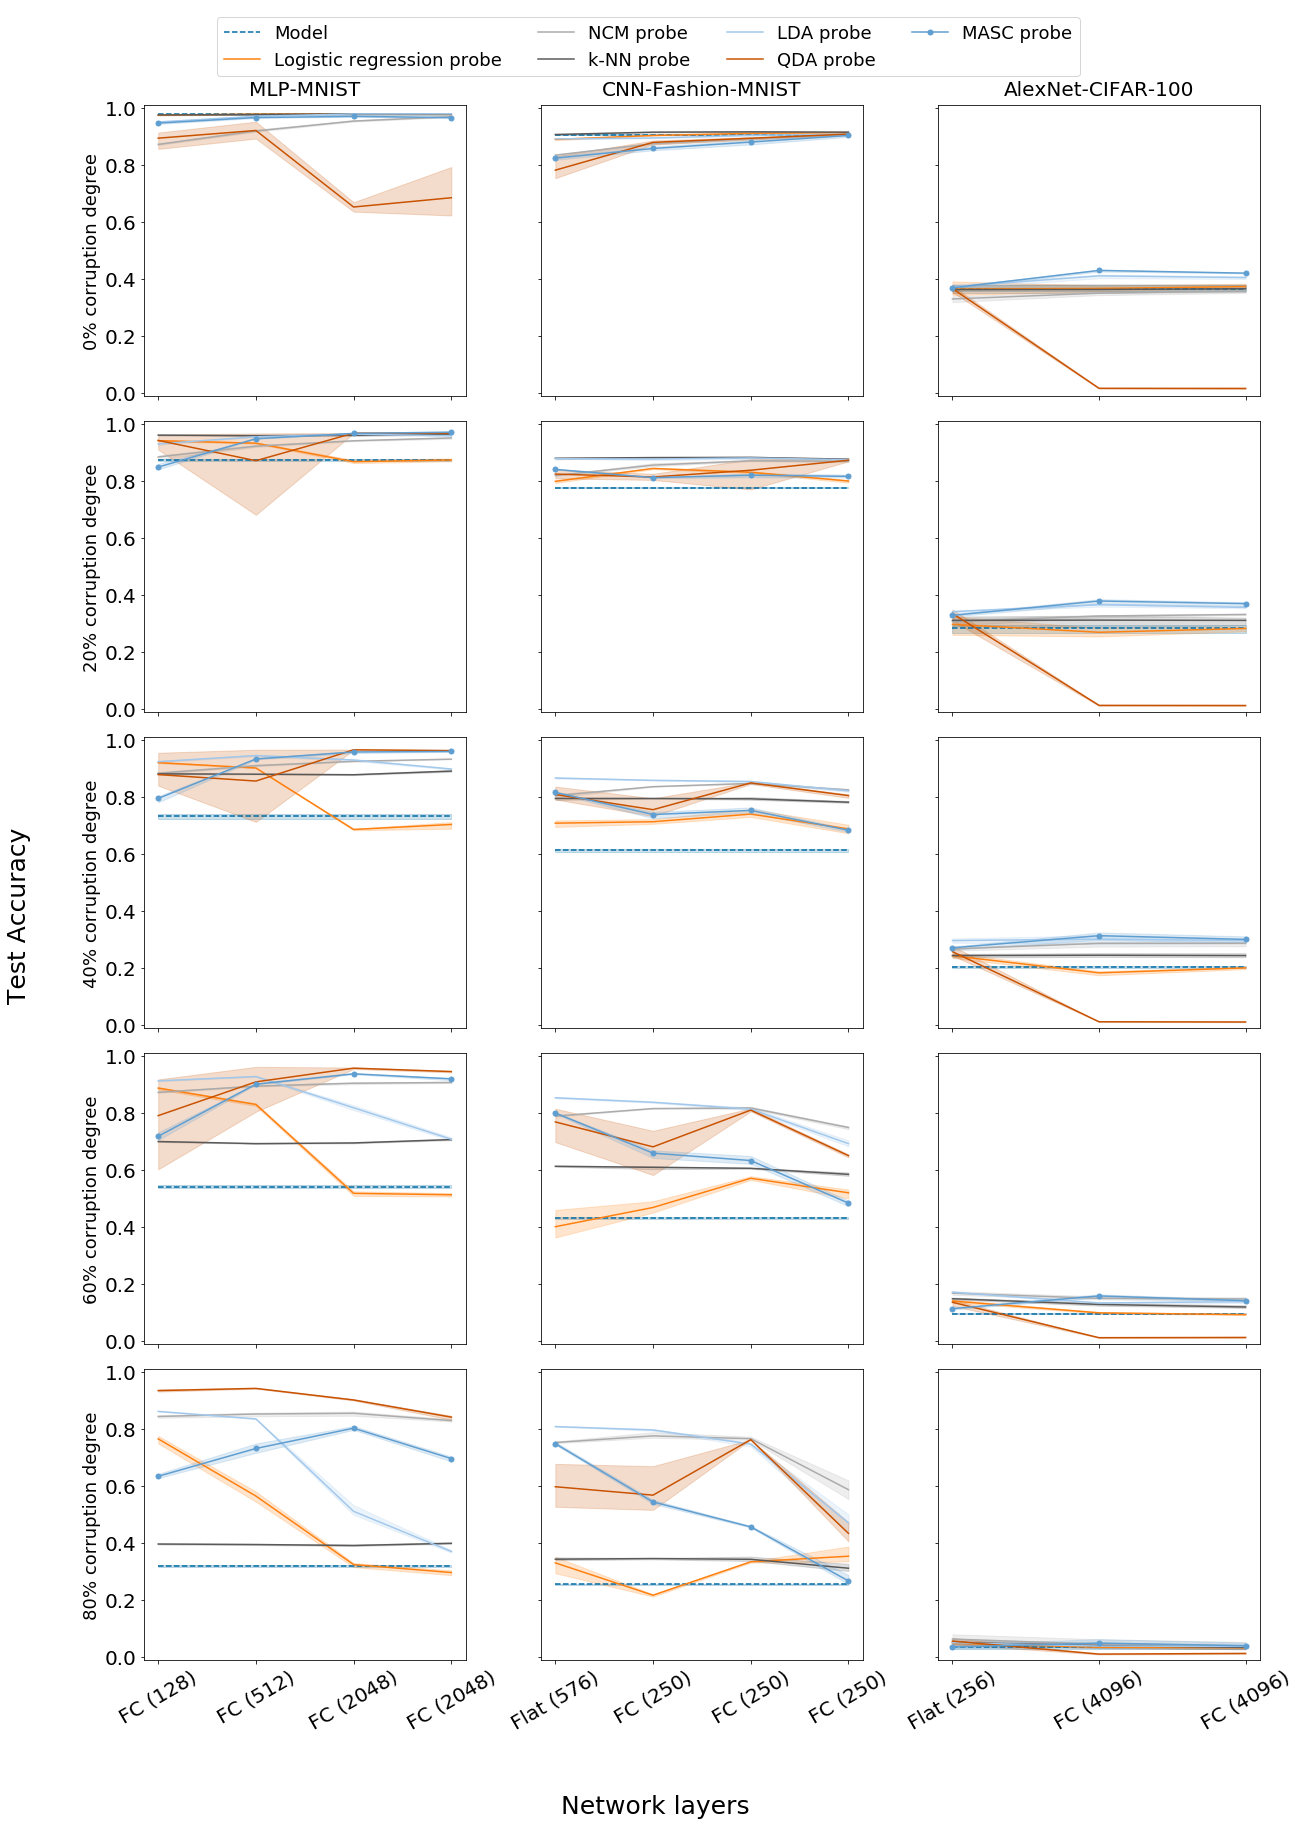

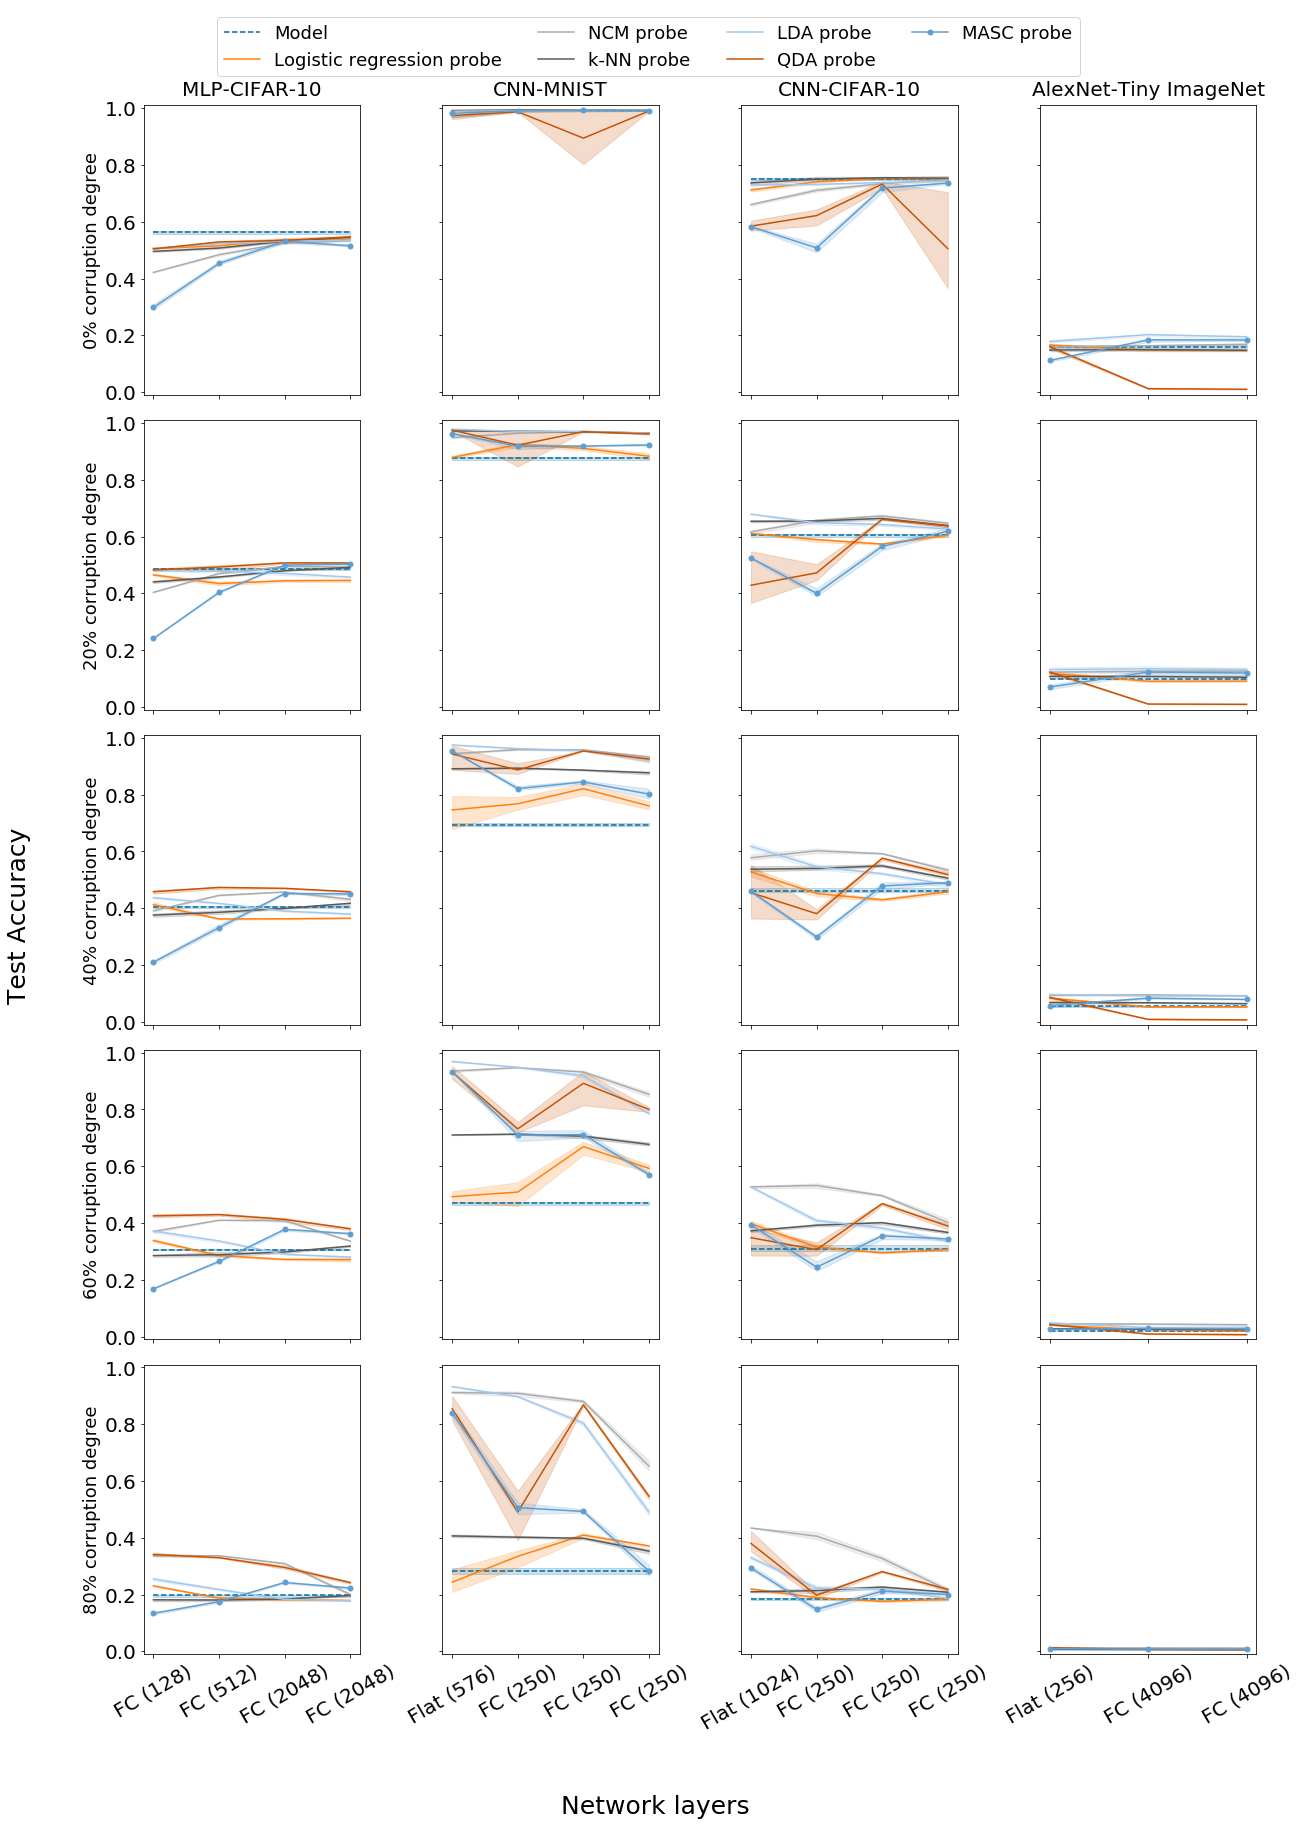

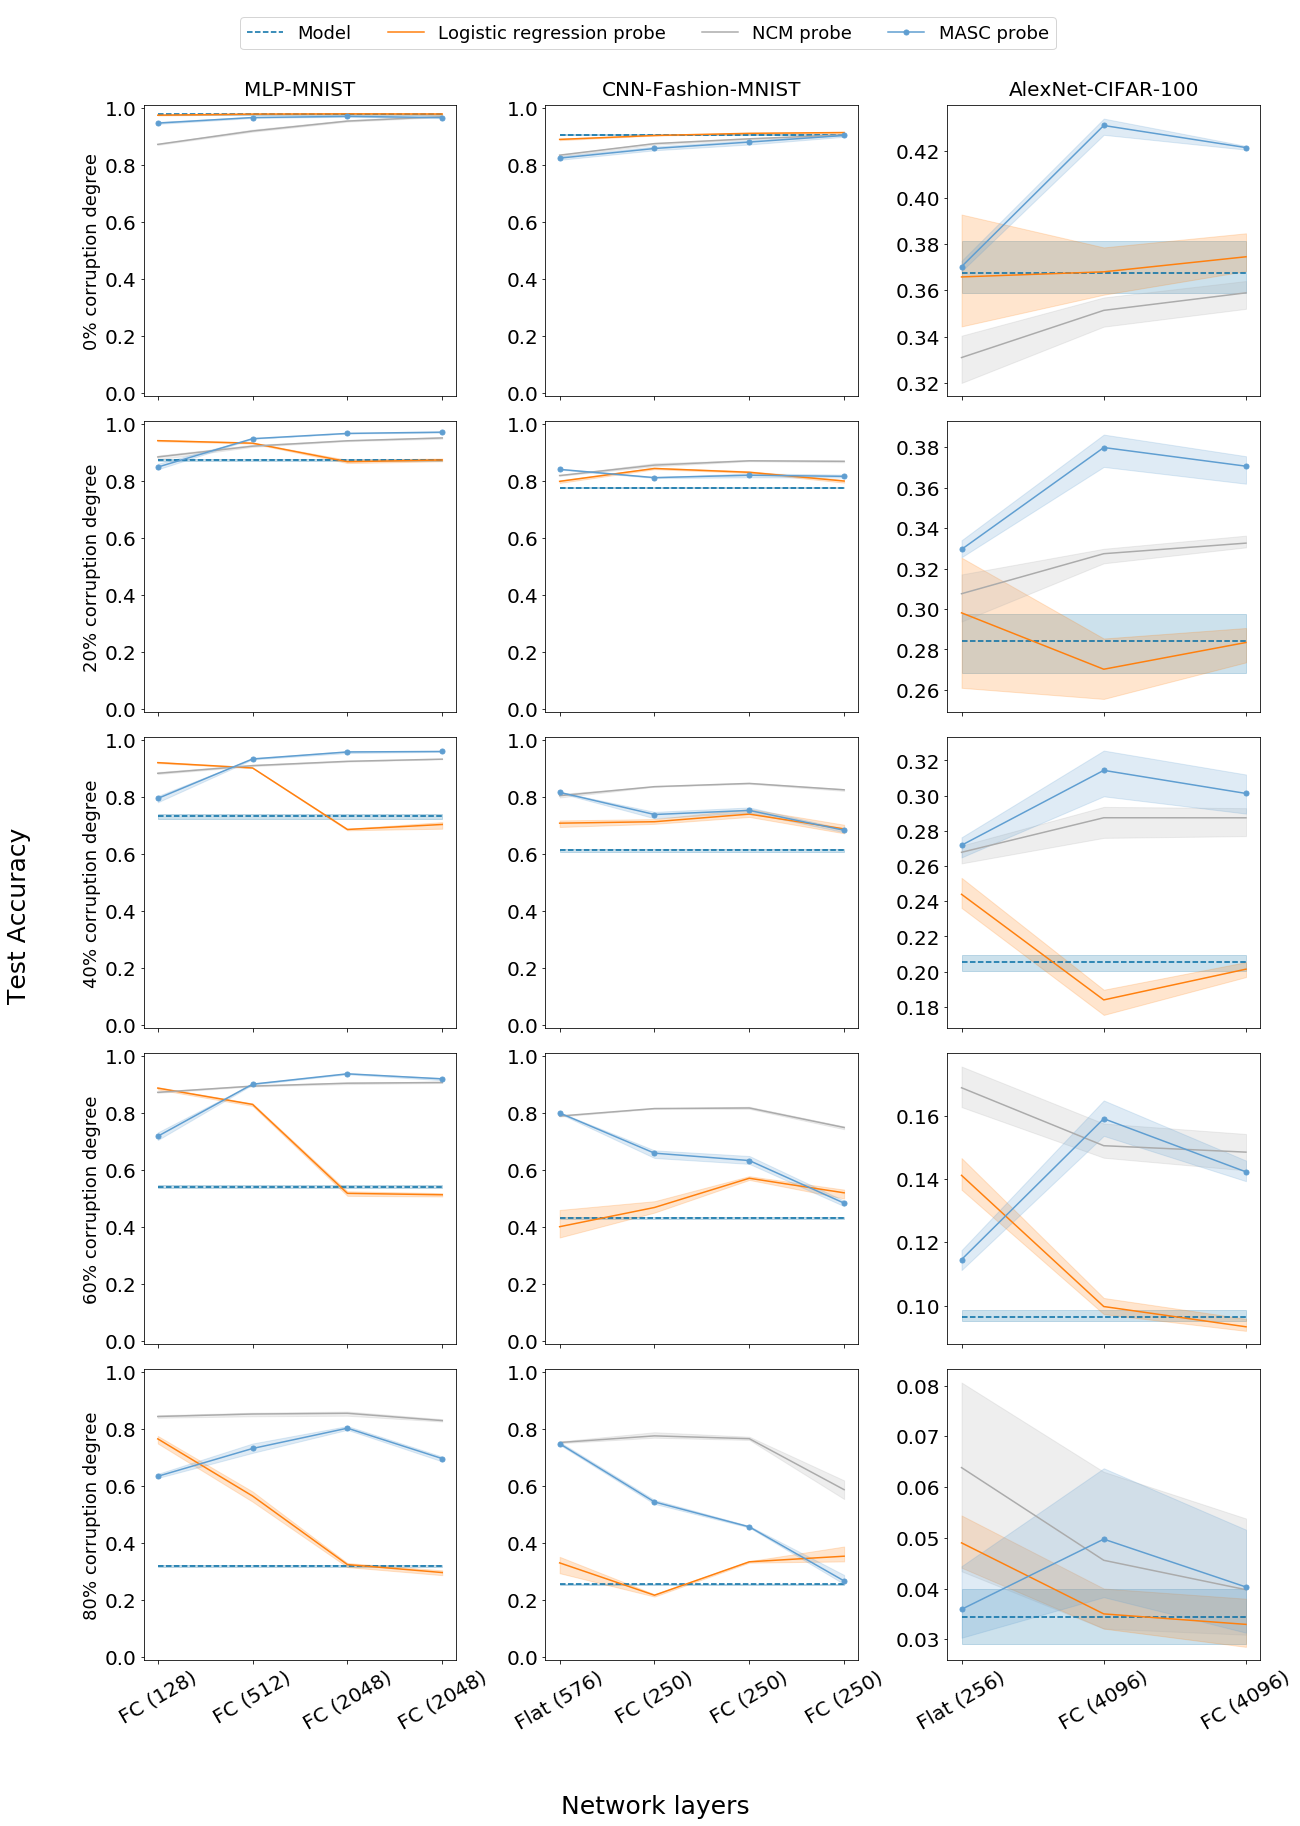

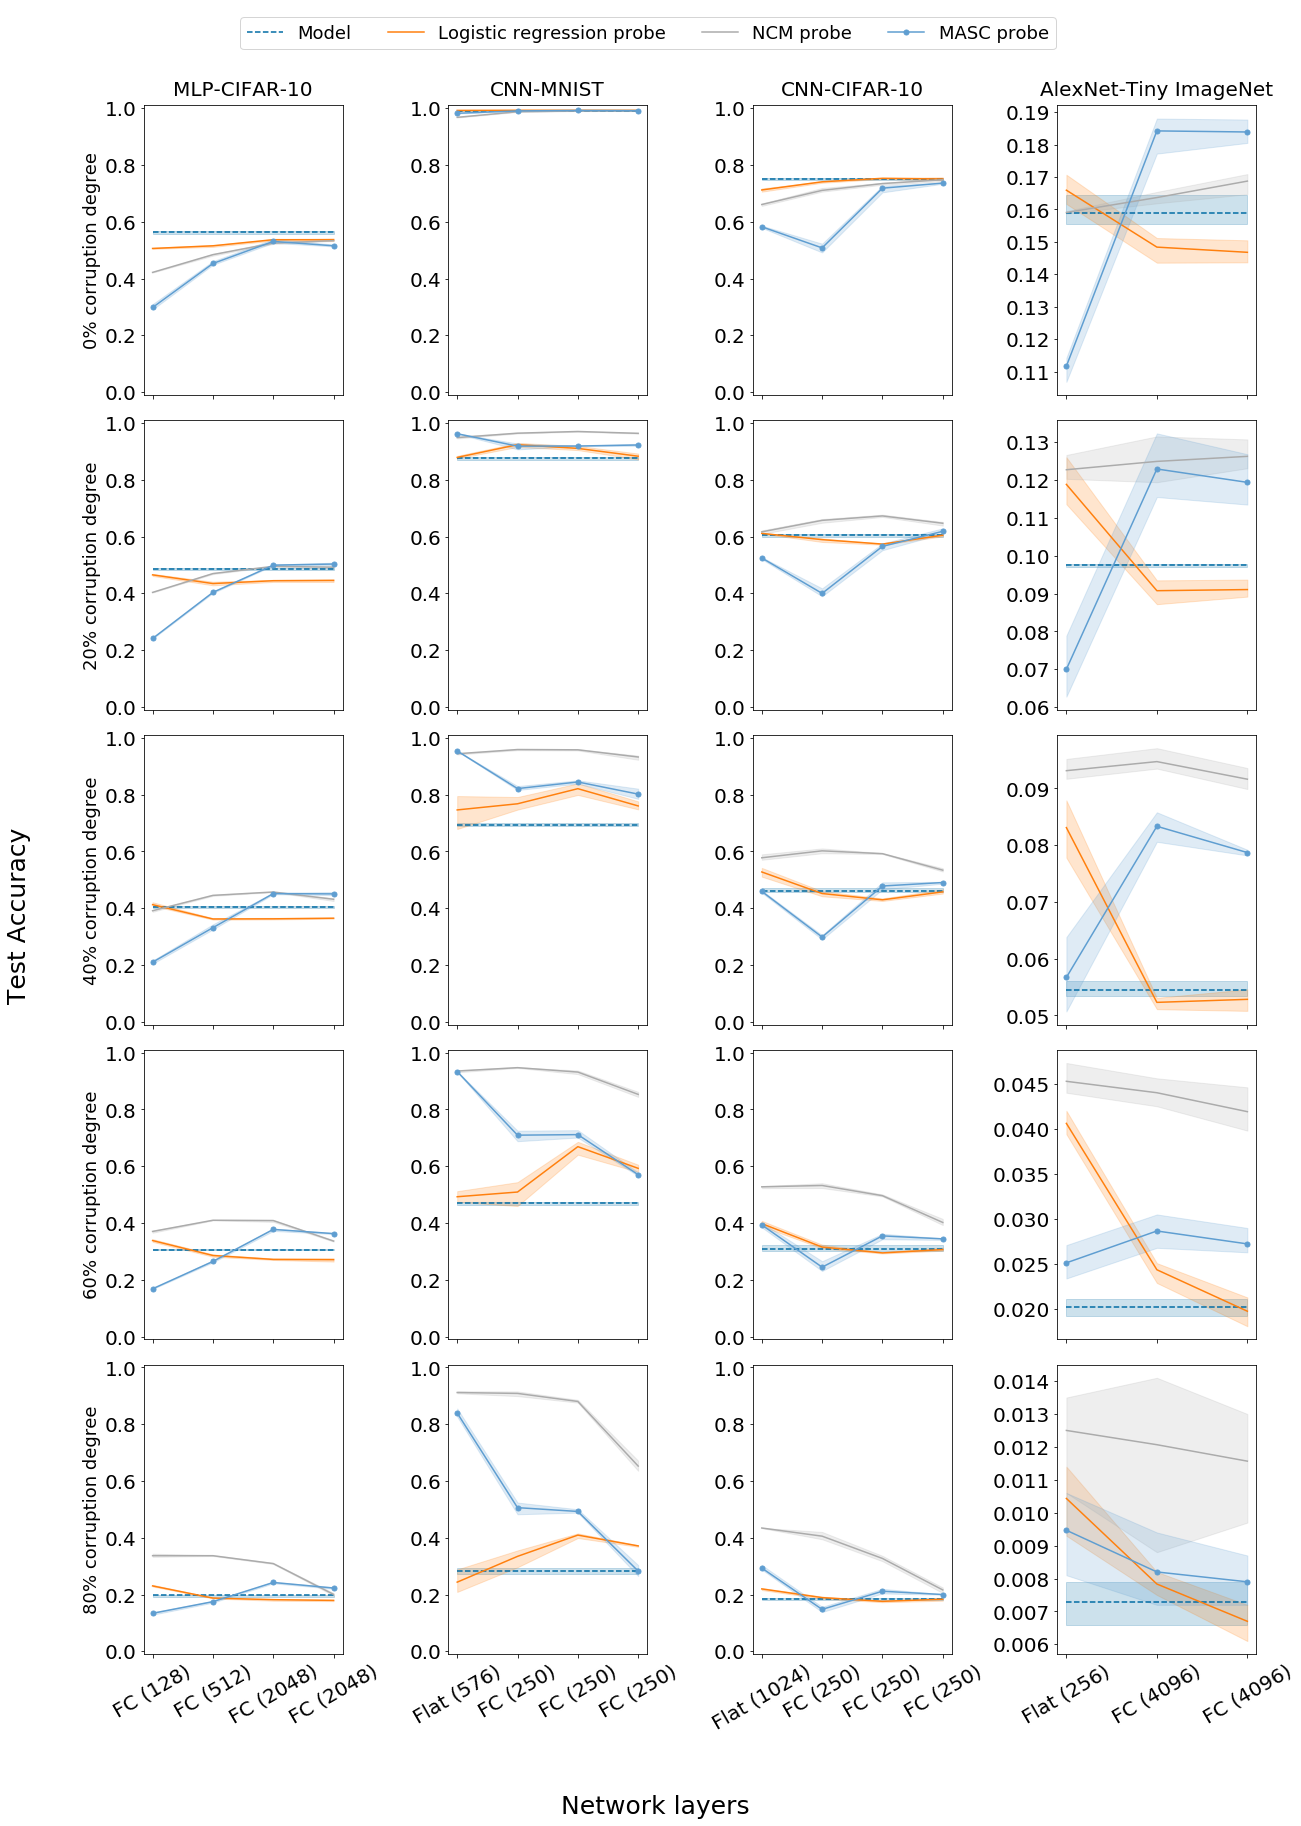

In [4]:
p1=plot_accuracy()

resfoldername='plots/stronger_baselines'
os.makedirs(f'{resfoldername}',exist_ok=True)
subspace='corrupt'
p1.plot_accuracy(resfoldername,subspace,other=False)
p1.plot_accuracy(resfoldername,subspace,other=True)


p1.plot_accuracy_compare(resfoldername,subspace,other=False)
p1.plot_accuracy_compare(resfoldername,subspace,other=True)

In [5]:
class plot_total_time_flops(plotting_base):    
    
    def time_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        time_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            time_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                total_time=pd.read_csv(file_load)['training_probe time'][0]+pd.read_csv(file_load)['inference time'][0]
                
                time_layer.append(total_time)
            time_run.append(time_layer)
        return time_run
    
    def flops_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        flops_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            
            flops_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                total_flops=pd.read_csv(file_load)['training_probe flops'][0]+pd.read_csv(file_load)['inference flops'][0]
                flops_layer.append(total_flops)
            flops_run.append(flops_layer)
        return flops_run
    def prob_label_list(self,number,time):
        if time or number==1:
            probes=['Logistic regression','NCM','LDA','QDA','k-NN']
            color_number_add=2
        if number==2:
            probes=[ 'Logistic regression','NCM','LDA','QDA']
            color_number_add=2
            
        if number==3:
            probes=[ 'Logistic regression','NCM']
            color_number_add=2
            
        return probes,color_number_add
    
    def plot_time_flops_probe(self,resfoldername,subspace,other,flops=False,time=False):
        colors_blind=[ '#006BA4','#5F9ED1','#FF800E', '#ABABAB','#595959', '#A2C8EC','#C85200']
        
        if time:
            y_label='Time taken (in sec)'
            name_file_pre='TIME'

        if flops:
            y_label='Computational cost (GFLOPs)'   
            name_file_pre='FLOPS'
            
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'{name_file_pre}_{subspace}_other_all.pdf'
            count_number=8
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'{name_file_pre}_{subspace}_all.pdf'
            count_number=6
            self.col=3 
        labels={'label1':f'Logistic regression probe',
               'label2':f'NCM probe',
                'label3':f'LDA probe',
                'label4':f'QDA probe',
                'label5':f'k-NN probe',
                'label6':'MASC probe'}
            
        num_rows=3
        figure_size=(15,10)
        fig = plt.figure(figsize=figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for number in range(1,4):
            probes,color_number_add=self.prob_label_list(number,time)

    #         for corrupt in self.corruptions:   
            corrupt=0.0
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(num_rows, self.col,count)
                for i,probe in enumerate(probes):

                    probe_folder=self.get_folder_name(probe)
                    file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                    masc=False
                    if time:
                        train_run=self.time_probe(type_network,ds,corrupt,file_path,masc)                    
                    if flops:
                        train_run=self.flops_probe(type_network,ds,corrupt,file_path,masc)
                        
                    max_value,min_value,avg_value=self.fun_1(train_run)
                    if probe=='Logistic regression' or probe=='NCM':
                        avg_value = [x / 1e9 for x in avg_value]
                        min_value = [x / 1e9 for x in min_value]
                        max_value = [x / 1e9 for x in max_value]

                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'-',markersize=self.markersize,label=labels[f'label{i+1}']
                             ,color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_'
                                     ,color=colors_blind[i+2])

                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)

                if count<=count_number:
                    probe='MASC'
                    file_path=self.path_masc(ds,type_network,corrupt,subspace)
                    masc=True
                    if time:
                        train_run=self.time_probe(type_network,ds,corrupt,file_path,masc)                    
                    if flops:
                        train_run=self.flops_probe(type_network,ds,corrupt,file_path,masc)

                    max_value,min_value,avg_value=self.fun_1(train_run)



        #                 print(avg_value)
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label6']
                             ,color=colors_blind[1])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_'
                                     ,color=colors_blind[1])

                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize-4)
                plt.yticks(fontsize=self.y_fontsize-4)
#                 if (count - 1) % self.col == 0:
#                     plt.ylabel(f'a',fontsize=self.title_font)
    #                 else:
    #                     plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize-2,pad=self.pad_value)
                if count<= (self.col*num_rows)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        
        
        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=3,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.90])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label-2)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label-2)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        
                                

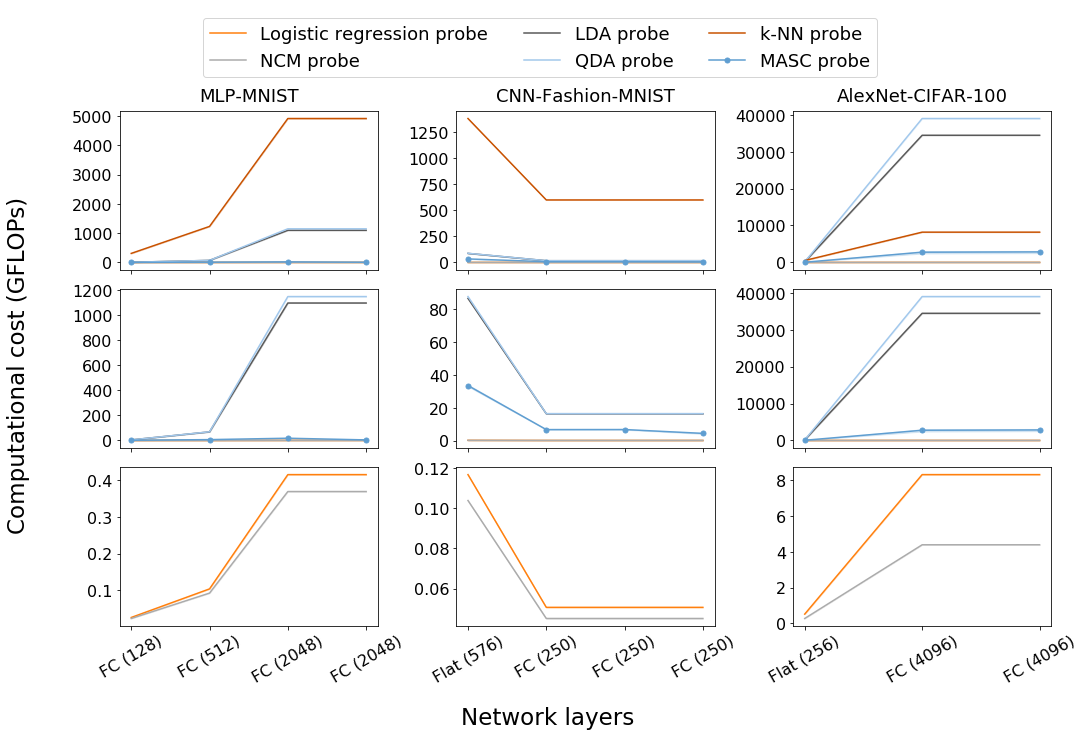

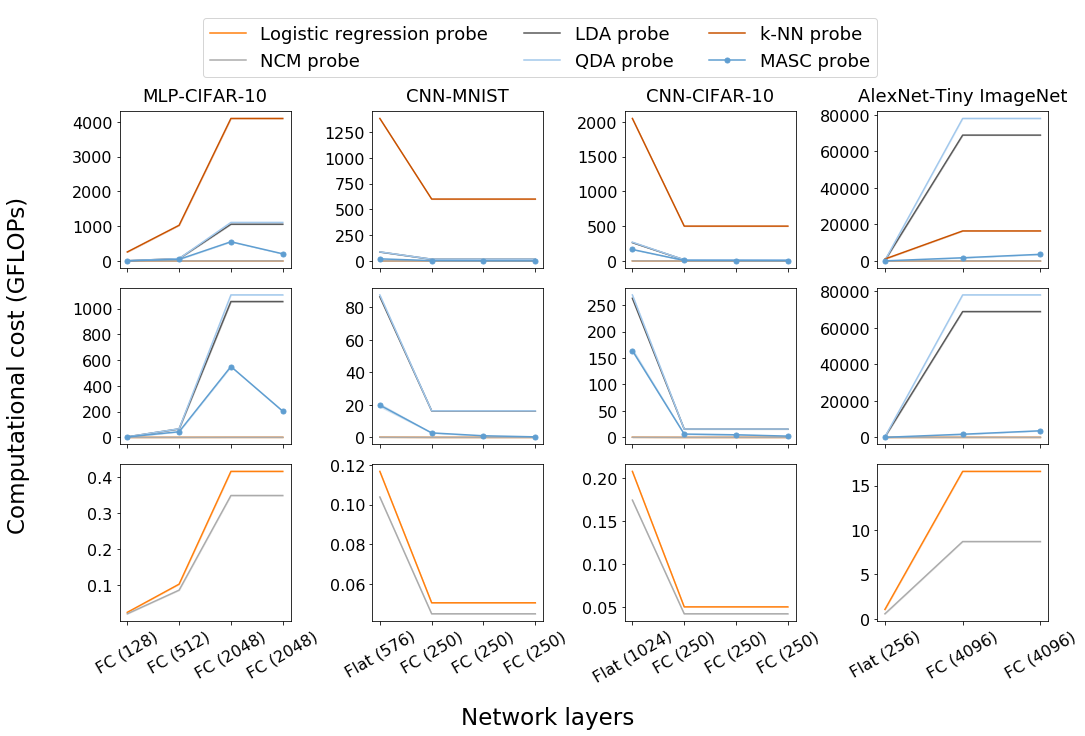

In [6]:
p1=plot_total_time_flops()
subspace='corrupt'

resfoldername='plots/stronger_baselines'
os.makedirs(f'{resfoldername}',exist_ok=True)
p1.plot_time_flops_probe(resfoldername,subspace,other=False,flops=True)
p1.plot_time_flops_probe(resfoldername,subspace,other=True,flops=True)

In [7]:
p1=plot_total_time_flops()

resfoldername='plots/stronger_baselines'
os.makedirs(f'{resfoldername}',exist_ok=True)
#time
subspace='corrupt'
p1.plot_time_flops_probe(resfoldername,subspace,other=False,time=True,number=1)
p1.plot_time_flops_probe(resfoldername,subspace,other=True,time=True,number=1)



TypeError: plot_time_flops_probe() got an unexpected keyword argument 'number'

In [54]:
       
class plot_time_flops(plotting_base):    
    
    def time_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        train_time_run=[]
        test_time_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            train_time_layer=[]
            test_time_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                train_time_layer.append(pd.read_csv(file_load)['training_probe time'][0])
                test_time_layer.append(pd.read_csv(file_load)['inference time'][0])
            train_time_run.append(train_time_layer)
            test_time_run.append(test_time_layer)
        return train_time_run,test_time_run
    
    def flops_probe(self,type_network,ds,corrupt,file_path,masc=False):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        runs=4
        train_flops_run=[]
        test_flops_run=[]
        for run in range(1,runs): 
            epoch_present=bc.get_epoch_present(type_network,ds,corrupt,run)
            if masc:
                epoch_present=epoch_present-1
            results_path=f'{file_path}/Run_{run}/{epoch_present}'
            
            train_flops_layer=[]
            test_flops_layer=[]
            for p_layer in pca_layer:
                file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
                train_flops_layer.append(pd.read_csv(file_load)['training_probe flops'][0])
                test_flops_layer.append(pd.read_csv(file_load)['inference flops'][0])
            train_flops_run.append(train_flops_layer)
            test_flops_run.append(test_flops_layer)
        return train_flops_run,test_flops_run
    
    def plot_time_flops_probe(self,resfoldername,subspace,other,flops=False,time=False,inference=False):
        if time:
            if inference:
                y_label='Inference time taken in sec'
            else:
                y_label='Training time taken in sec'
            name_file_pre='TIME'

            
        if flops:
            if inference:
                y_label='Inference GFLOPs taken'
            else:
                y_label='Training GFLOPs taken'
                
            name_file_pre='FLOPS'
        
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'{name_file_pre}_{subspace}_other.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'{name_file_pre}_{subspace}.pdf'
            self.col=3
        num_cols=6
        probes=['Logistic regression','NCM','k-NN', 'LDA','QDA']#

        labels={'label1':f'{probes[0]} probe',
                'label2':f'{probes[1]} probe',
               'label3':f'{probes[2]} probe',
               'label4':f'{probes[3]} probe',
               'label5':f'{probes[4]} probe'}#,
               #'label6':'MASC probe'

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(self.row, self.col,count)
                for i,probe in enumerate(probes):
                    if probe=='MASC':
                        file_path=self.path_masc(ds,type_network,corrupt,subspace)
                        masc=True
                    else:
                        probe_folder=self.get_folder_name(probe)
                        file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                        masc=False
                    if time:
                        train_run,test_run=self.time_probe(type_network,ds,corrupt,file_path,masc)                    
                    if flops:
                        train_run,test_run=self.flops_probe(type_network,ds,corrupt,file_path,masc)
                    if inference:
                        max_value,min_value,avg_value=self.fun_1(test_run)
                    else:
                        max_value,min_value,avg_value=self.fun_1(train_run)
                        
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'-',markersize=self.markersize,label=labels[f'label{i+1}'],color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',color=colors_blind[i+2])
                
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
#                 else:
#                     plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=3,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        
                                

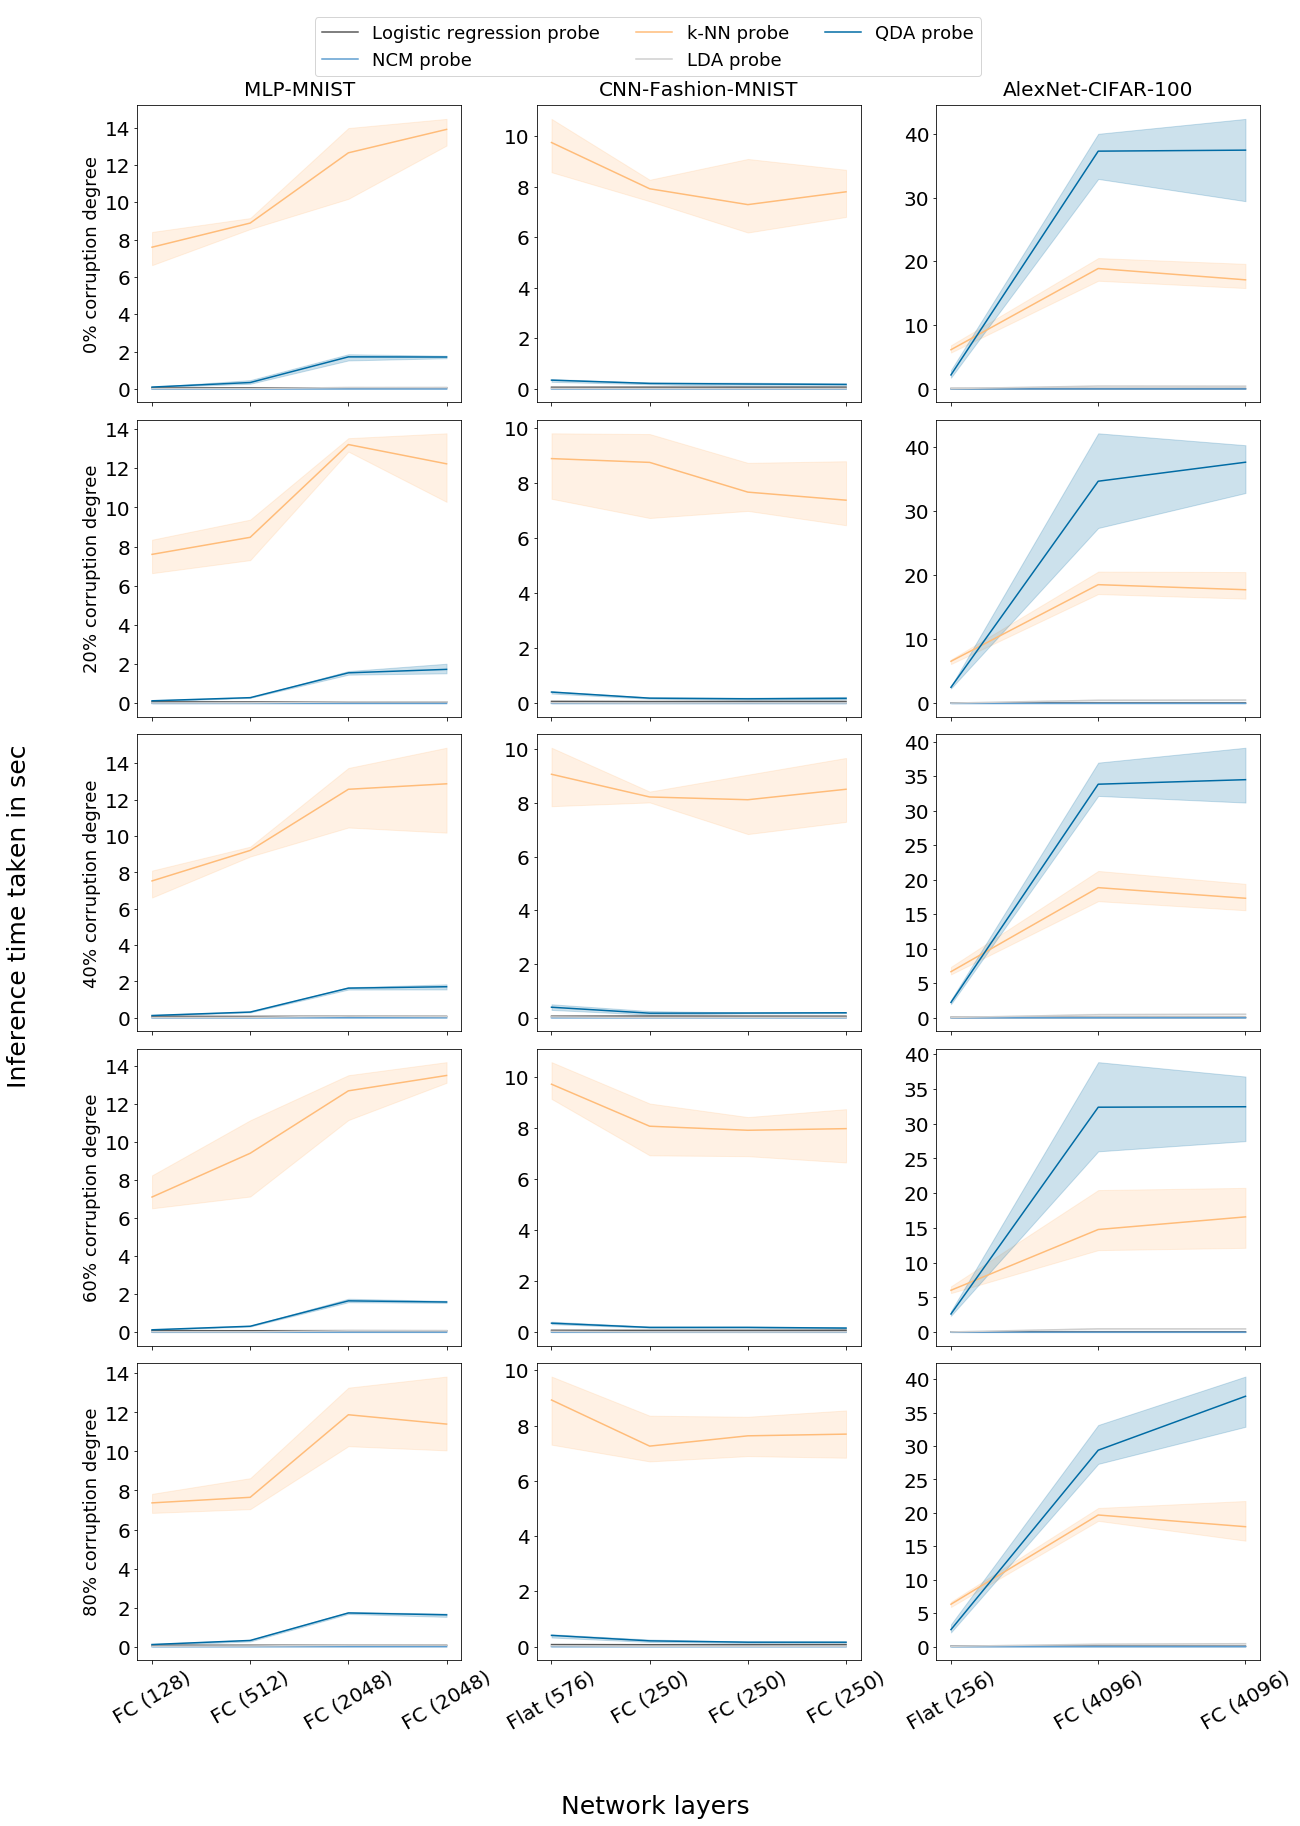

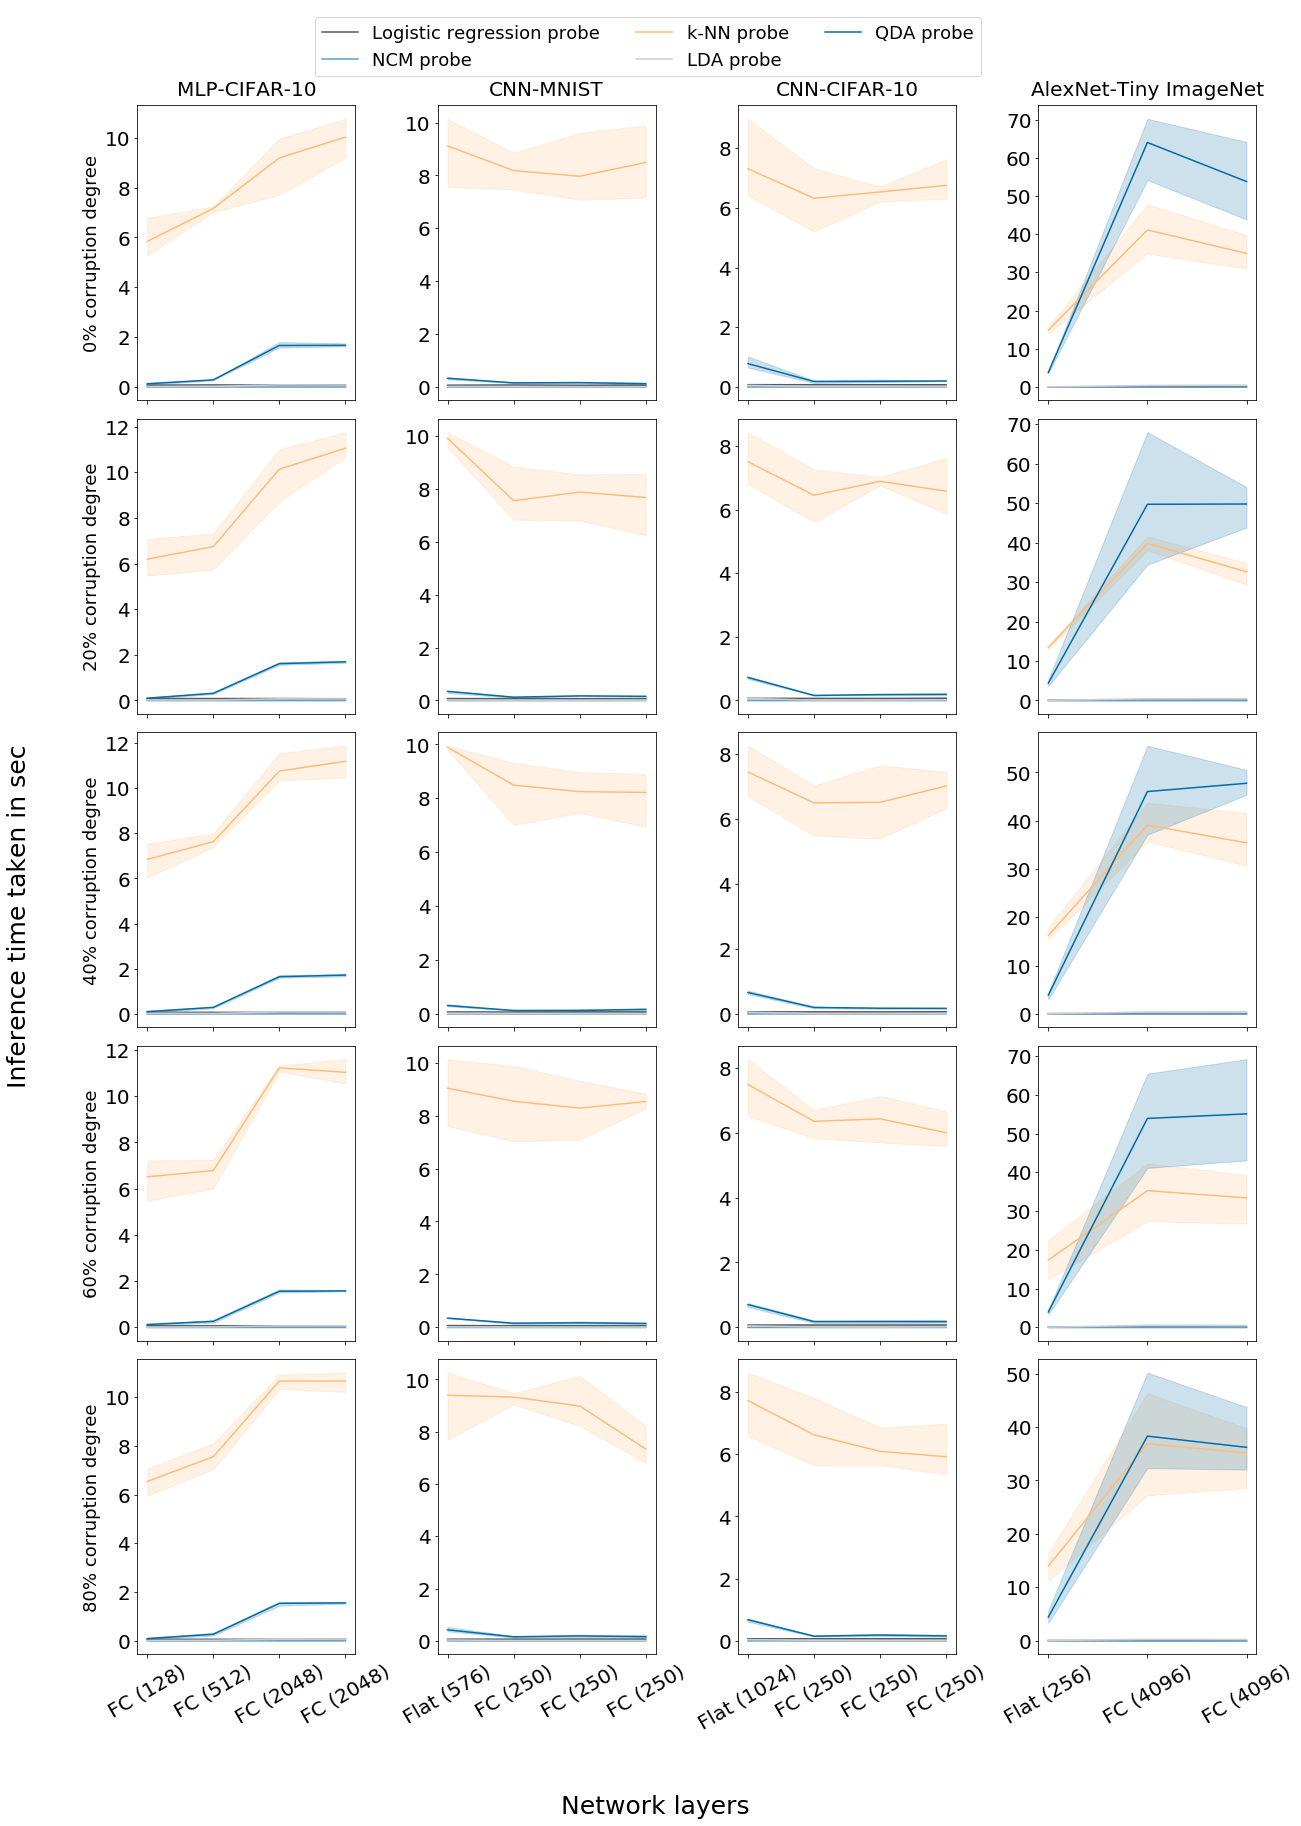

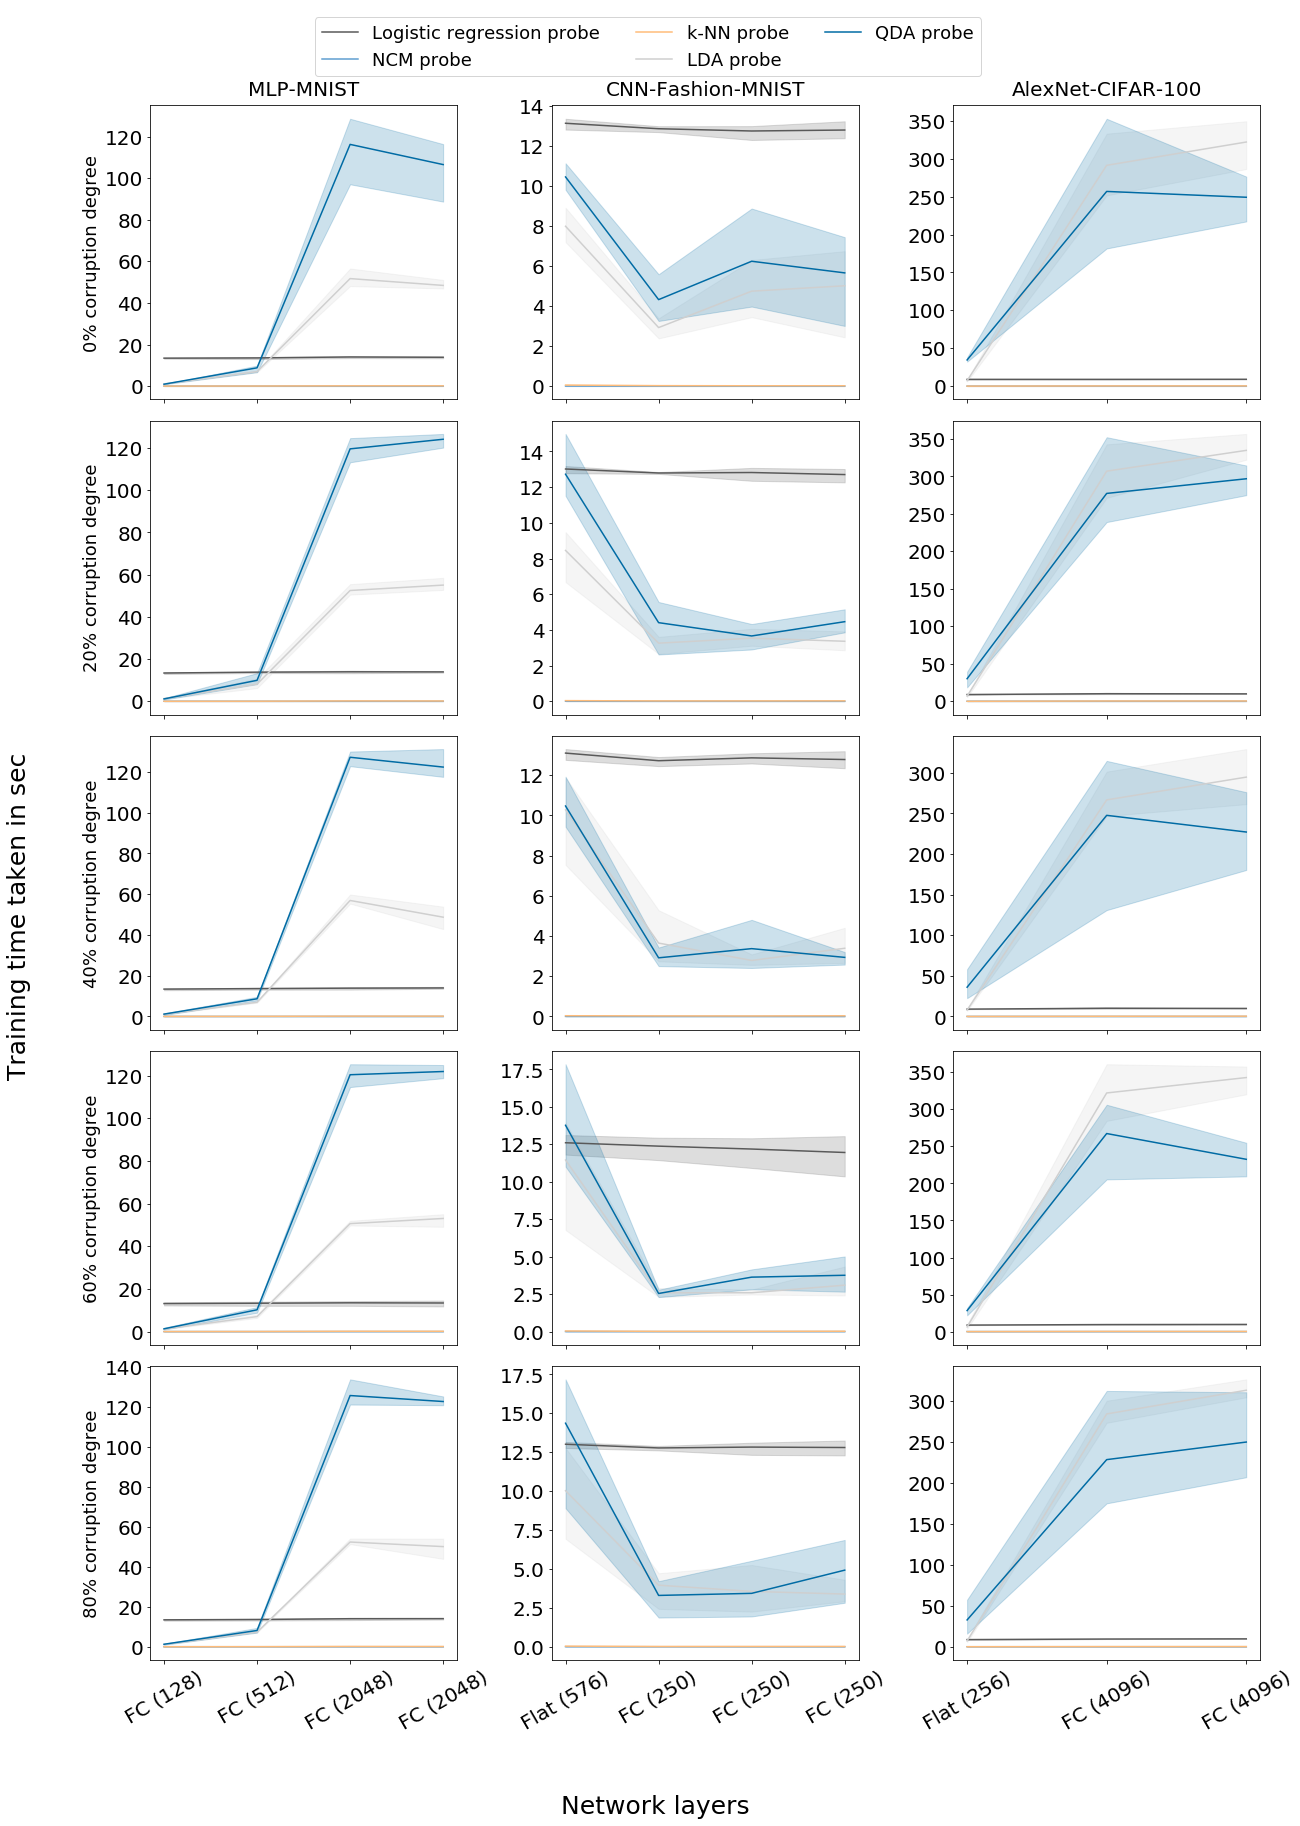

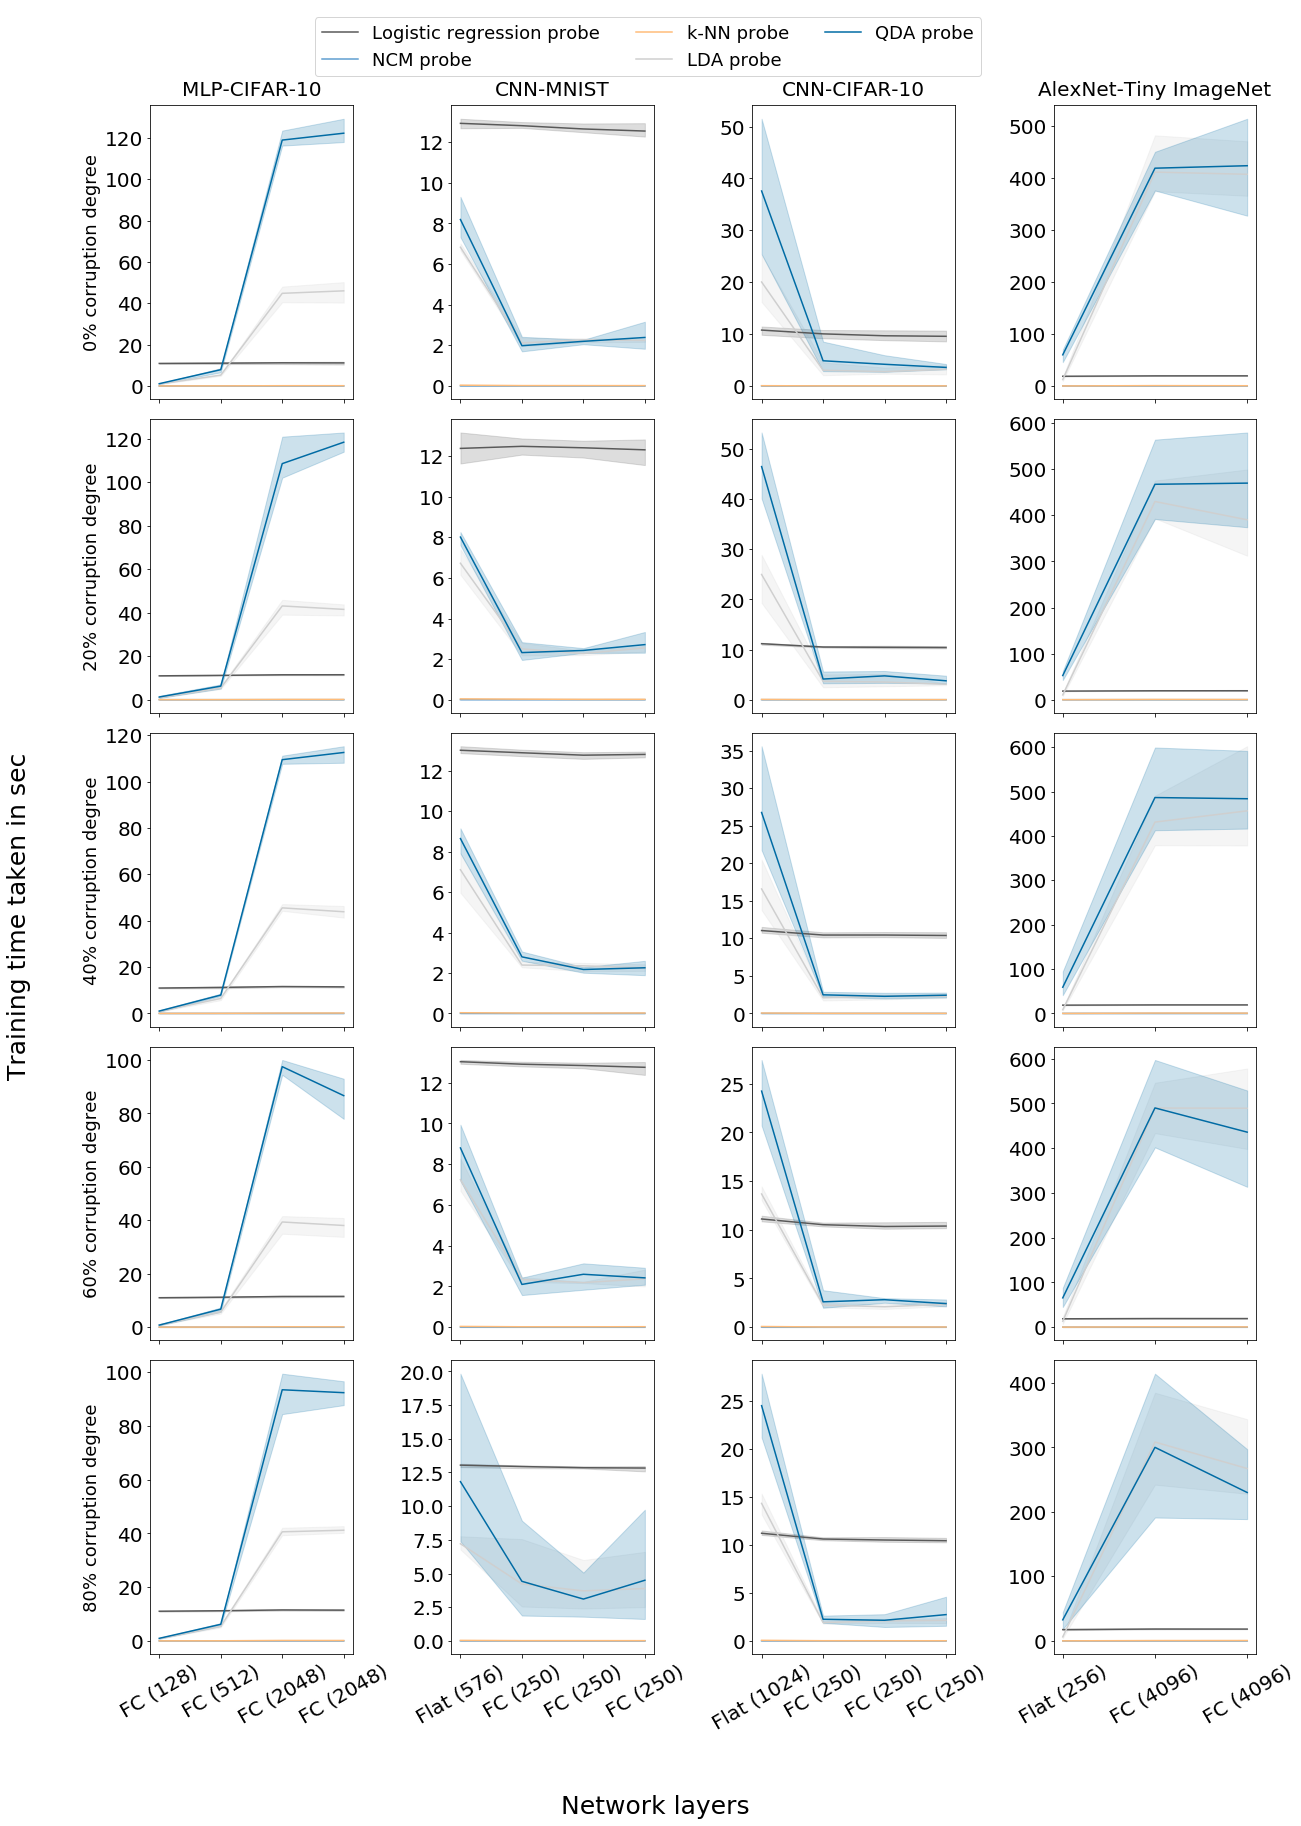

In [55]:
p1=plot_time_flops()

resfoldername='plots/stronger_baselines'
os.makedirs(f'{resfoldername}',exist_ok=True)
#time
subspace='corrupt'
p1.plot_time_flops_probe(resfoldername,subspace,other=False,time=True,inference=True)
p1.plot_time_flops_probe(resfoldername,subspace,other=True,time=True,inference=True)
p1.plot_time_flops_probe(resfoldername,subspace,other=False,time=True,inference=False)
p1.plot_time_flops_probe(resfoldername,subspace,other=True,time=True,inference=False)

#flops
subspace='corrupt'
# p1.plot_time_flops_probe(resfoldername,subspace,other=False,flops=True,inference=True)
# p1.plot_time_flops_probe(resfoldername,subspace,other=True,flops=True,inference=True)
# p1.plot_time_flops_probe(resfoldername,subspace,other=False,flops=True,inference=False)
# p1.plot_time_flops_probe(resfoldername,subspace,other=True,flops=True,inference=False)



In [94]:
class plot_extra(plot_accuracy):
    def plot_accuracy_probewise(self,resfoldername,subspace,probes,other):
        colors_blind=[ '#006BA4', '#5F9ED1','#FF800E', '#ABABAB', '#595959']
        y_label='Test Accuracy'
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_other_{probes}.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_{probes}.pdf'
            self.col=3
        num_cols=6
        
        

        labels={'label0':'Model',
                'label1':f'{probes[0]} probe',
               'label6':'MASC probe'} 

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(self.row, self.col,count)
                test_model=self.model_accuracy(ds,type_network,corrupt)
                max_value,min_value,avg_value=self.fun_1(test_model)
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'--',markersize=self.markersize,label=labels[f'label0'],color=colors_blind[0])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',color=colors_blind[0])
                for i,probe in enumerate(probes):
                    probe_folder=self.get_folder_name(probe)
                    file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                    test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe,masc=False)
                    max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,':',markersize=self.markersize,label=labels[f'label{i+1}'],
                            color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                    color=colors_blind[i+2])
                
#                 # MASC
                file_path=self.path_masc(ds,type_network,corrupt,subspace)
                test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe='MASC',masc=True)
                max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label6'],
                         color=colors_blind[1])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                 color=colors_blind[1])
                
#                 if type_network!='AlexNet':
                plt.ylim(-0.01,1.01)
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
                else:
                    plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=4,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}_{probes[0]}',format="pdf", bbox_inches="tight")
        
    def plot_accuracy_probewise2(self,resfoldername,subspace,probes,other):
#         colors_blind=[ '#FF800E', '#ABABAB', '#595959',
#                  '#5F9ED1',  '#FFBC79',  
#               '#006BA4','#CFCFCF','#C85200','#898989', '#A2C8EC',]
        colors_blind=[ '#006BA4', '#5F9ED1','#FF800E', '#ABABAB','#595959', ]#'#006BA4',
        y_label='Test Accuracy'
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']
            type_networks=['MLP','CNN','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_other_{probes}.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']
            type_networks=['MLP','CNN','AlexNet']
            file_name=f'ACCURACY_compare_{subspace}_{probes}.pdf'
            self.col=3
        num_cols=6

        labels={'label0':'Model',
                'label1':f'{probes[0]} probe',
                'label2':f'{probes[1]} probe',
                'label3':f'{probes[2]} probe',
               'label6':'MASC probe'} #
        

#                'label4':f'{probes[3]} probe',
#                 'label5':f'{probes[4]} probe',

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
                fig.add_subplot(self.row, self.col,count)
                test_model=self.model_accuracy(ds,type_network,corrupt)
                max_value,min_value,avg_value=self.fun_1(test_model)
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'--',markersize=self.markersize,label=labels[f'label0'],color=colors_blind[0])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',color=colors_blind[0])
                for i,probe in enumerate(probes):
                    probe_folder=self.get_folder_name(probe)
                    file_path=self.path_results(ds,type_network,corrupt,subspace,probe_folder)
                    test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe,masc=False)
                    max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    x,layers=self.layernames(type_network,ds)
                    plt.plot(x,avg_value,'-',markersize=self.markersize,label=labels[f'label{i+1}'],
                            color=colors_blind[i+2])
                    plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                    color=colors_blind[i+2])
                
#                 # MASC
                file_path=self.path_masc(ds,type_network,corrupt,subspace)
                test_acc_run=self.acc_probe(type_network,ds,corrupt,file_path,probe='MASC',masc=True)
                max_value,min_value,avg_value=self.fun_1(test_acc_run)
                    
                x,layers=self.layernames(type_network,ds)
                plt.plot(x,avg_value,'o-',markersize=self.markersize,label=labels[f'label6'],
                         color=colors_blind[1])
                plt.fill_between(x,min_value, max_value, alpha=.2,label='_nolegend_',
                                 color=colors_blind[1])
                
#                 if type_network!='AlexNet':
                plt.ylim(-0.01,1.01)
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
                else:
                    plt.tick_params(labelleft=False)
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=4,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        

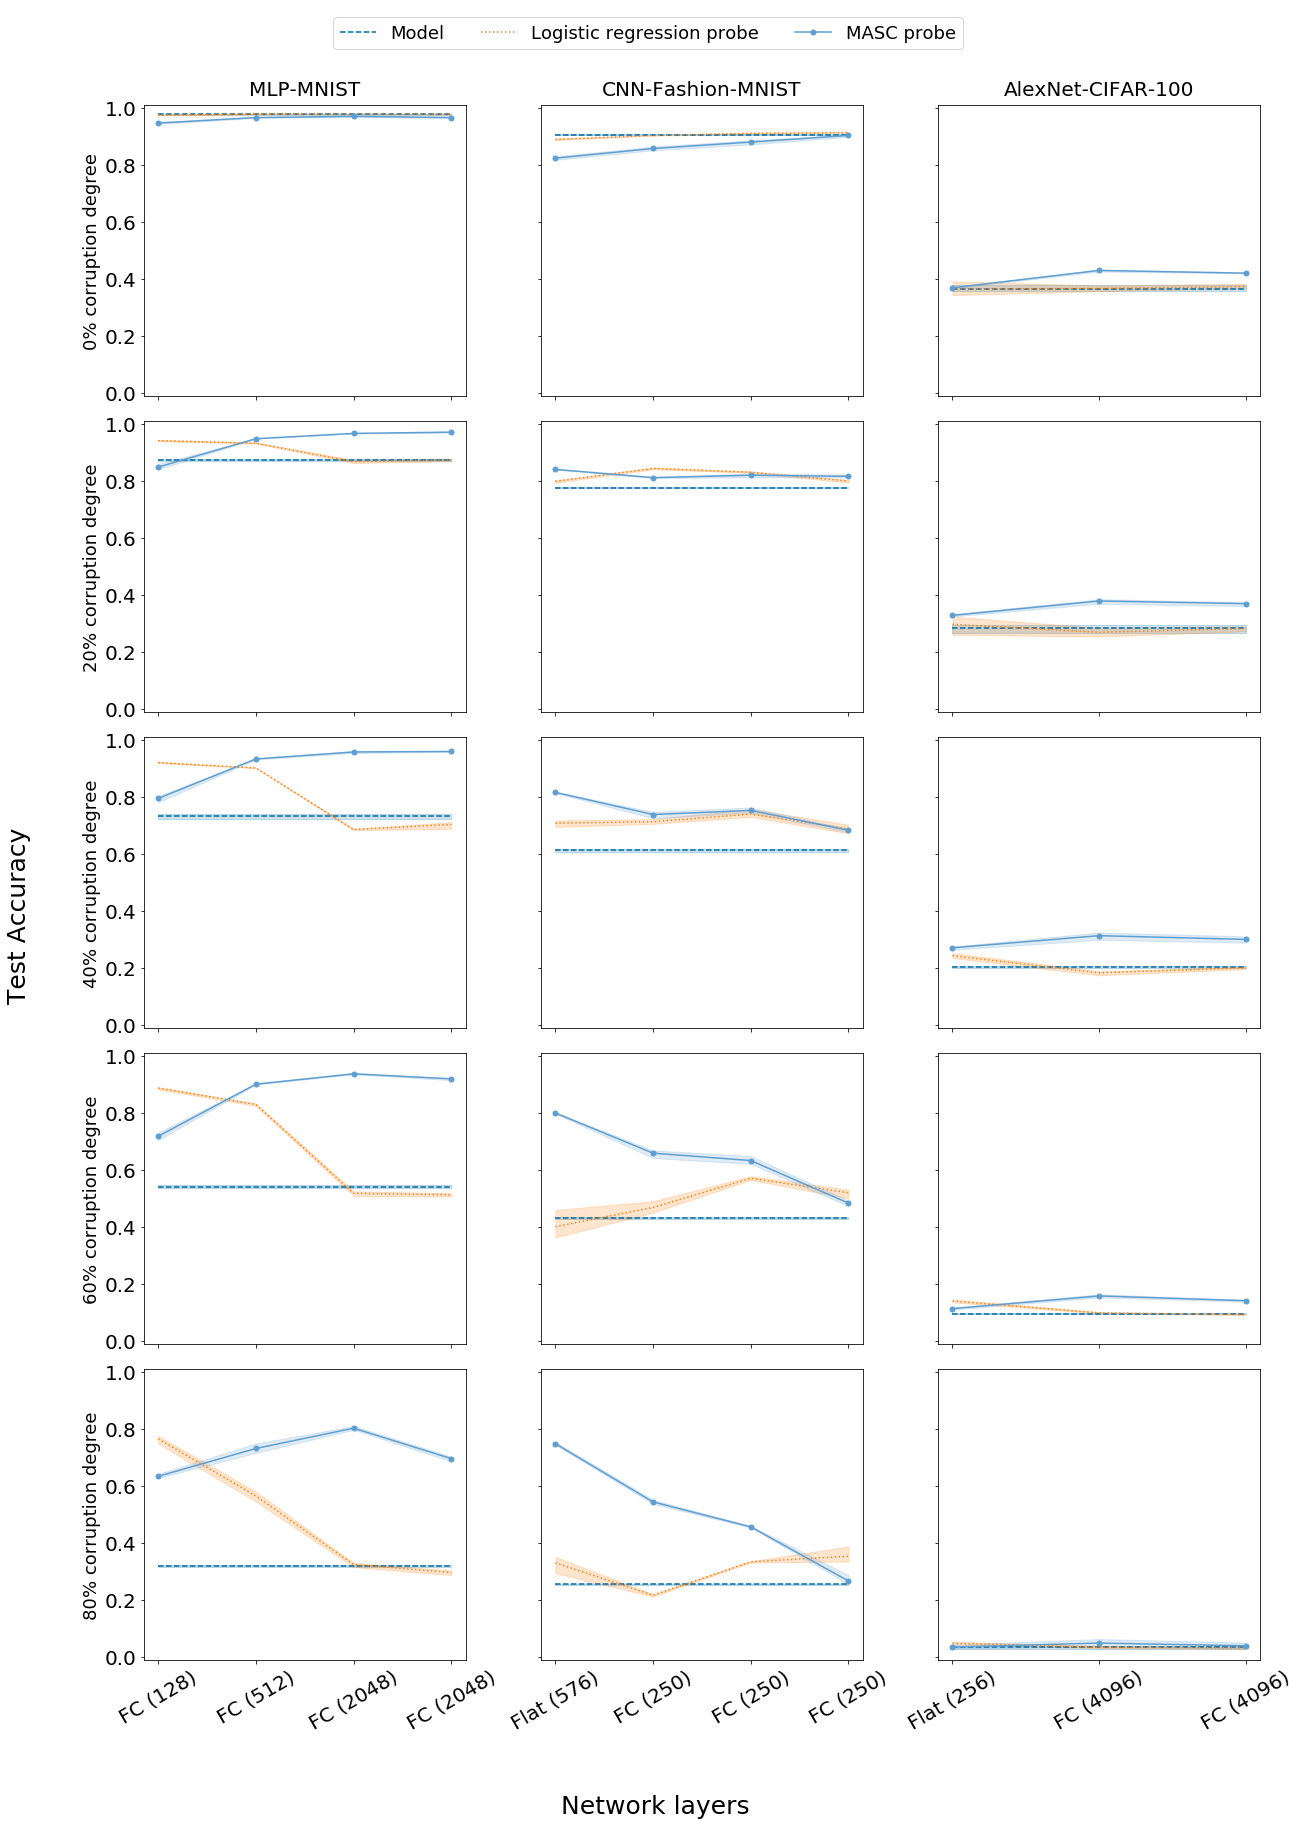

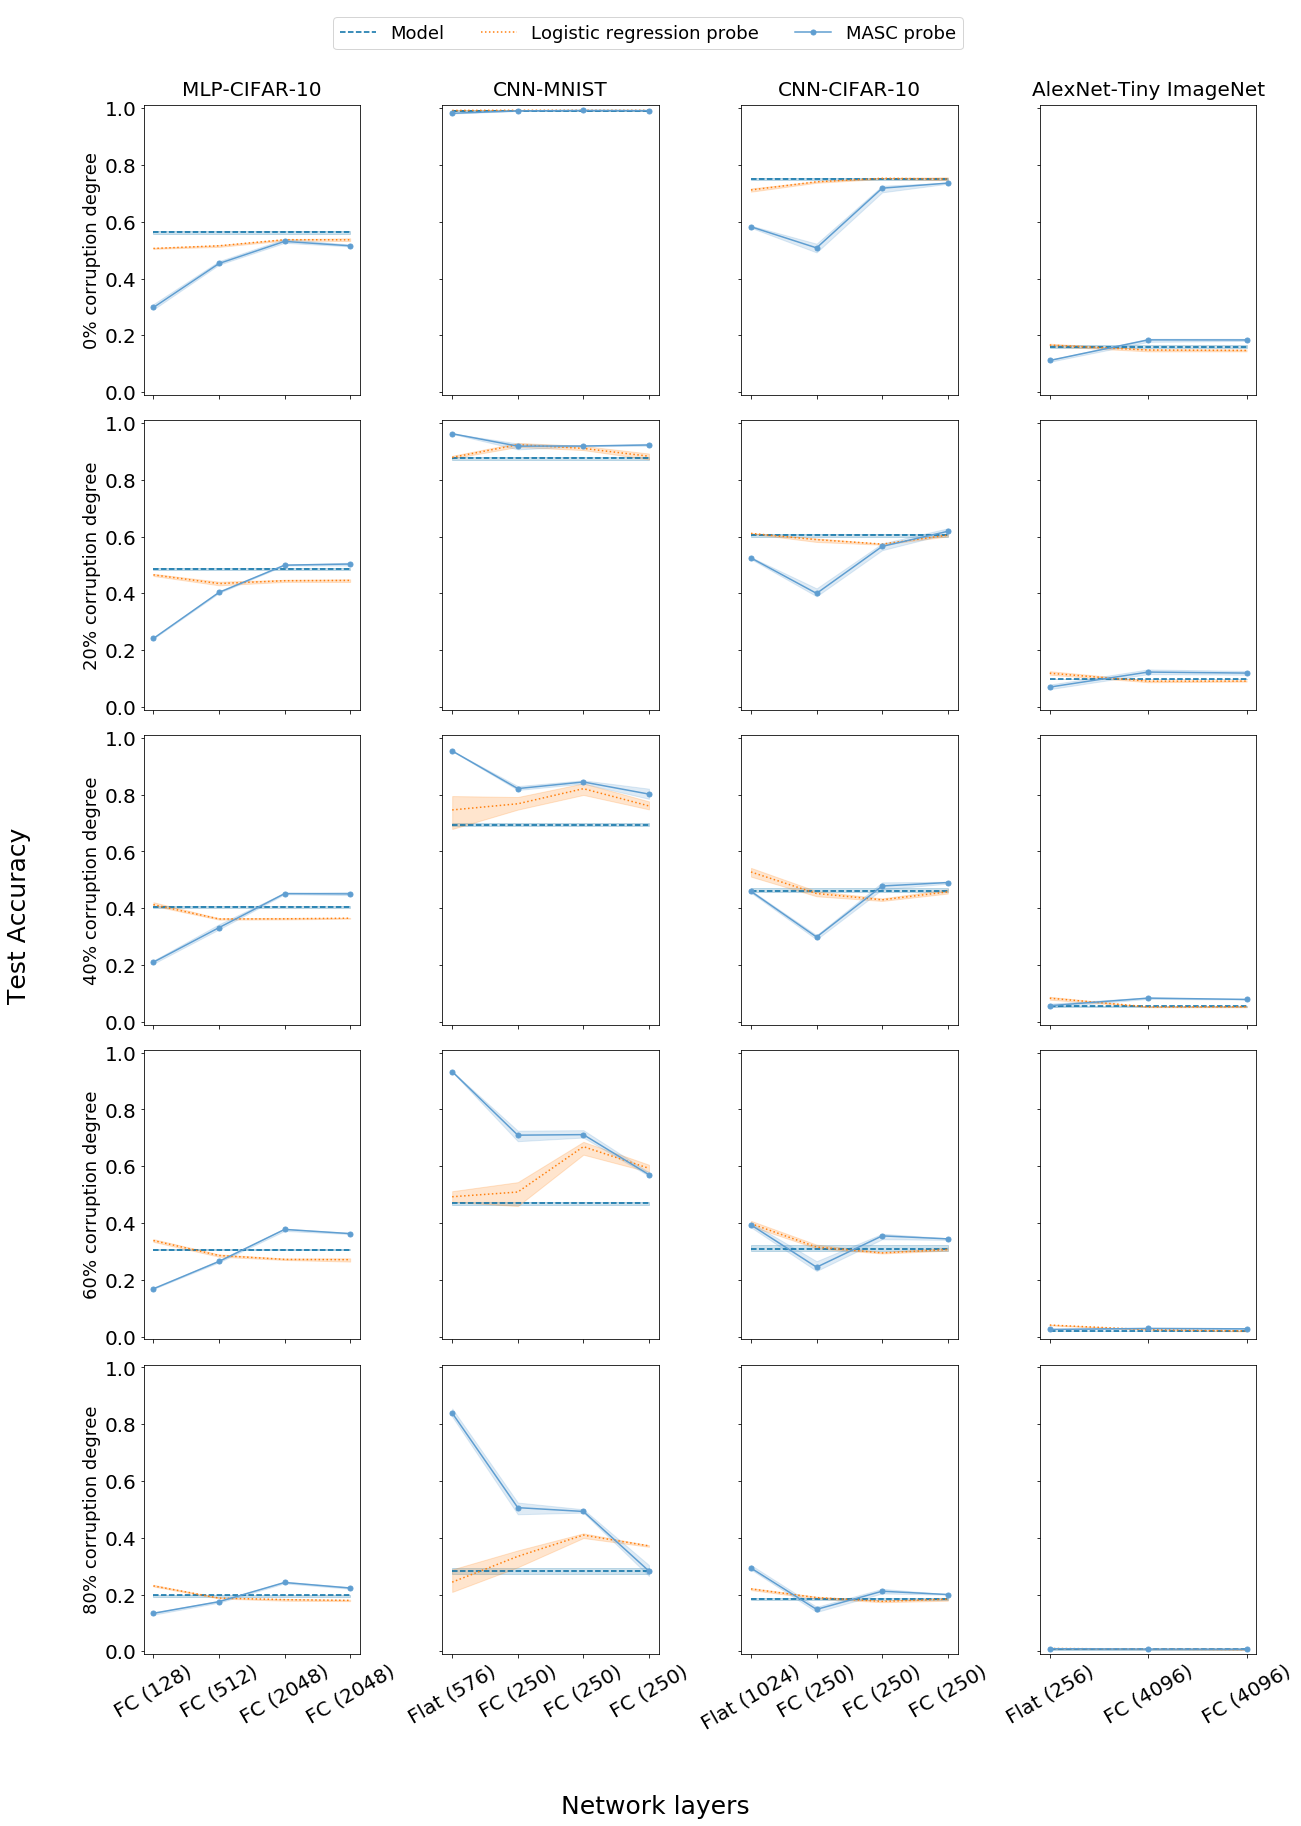

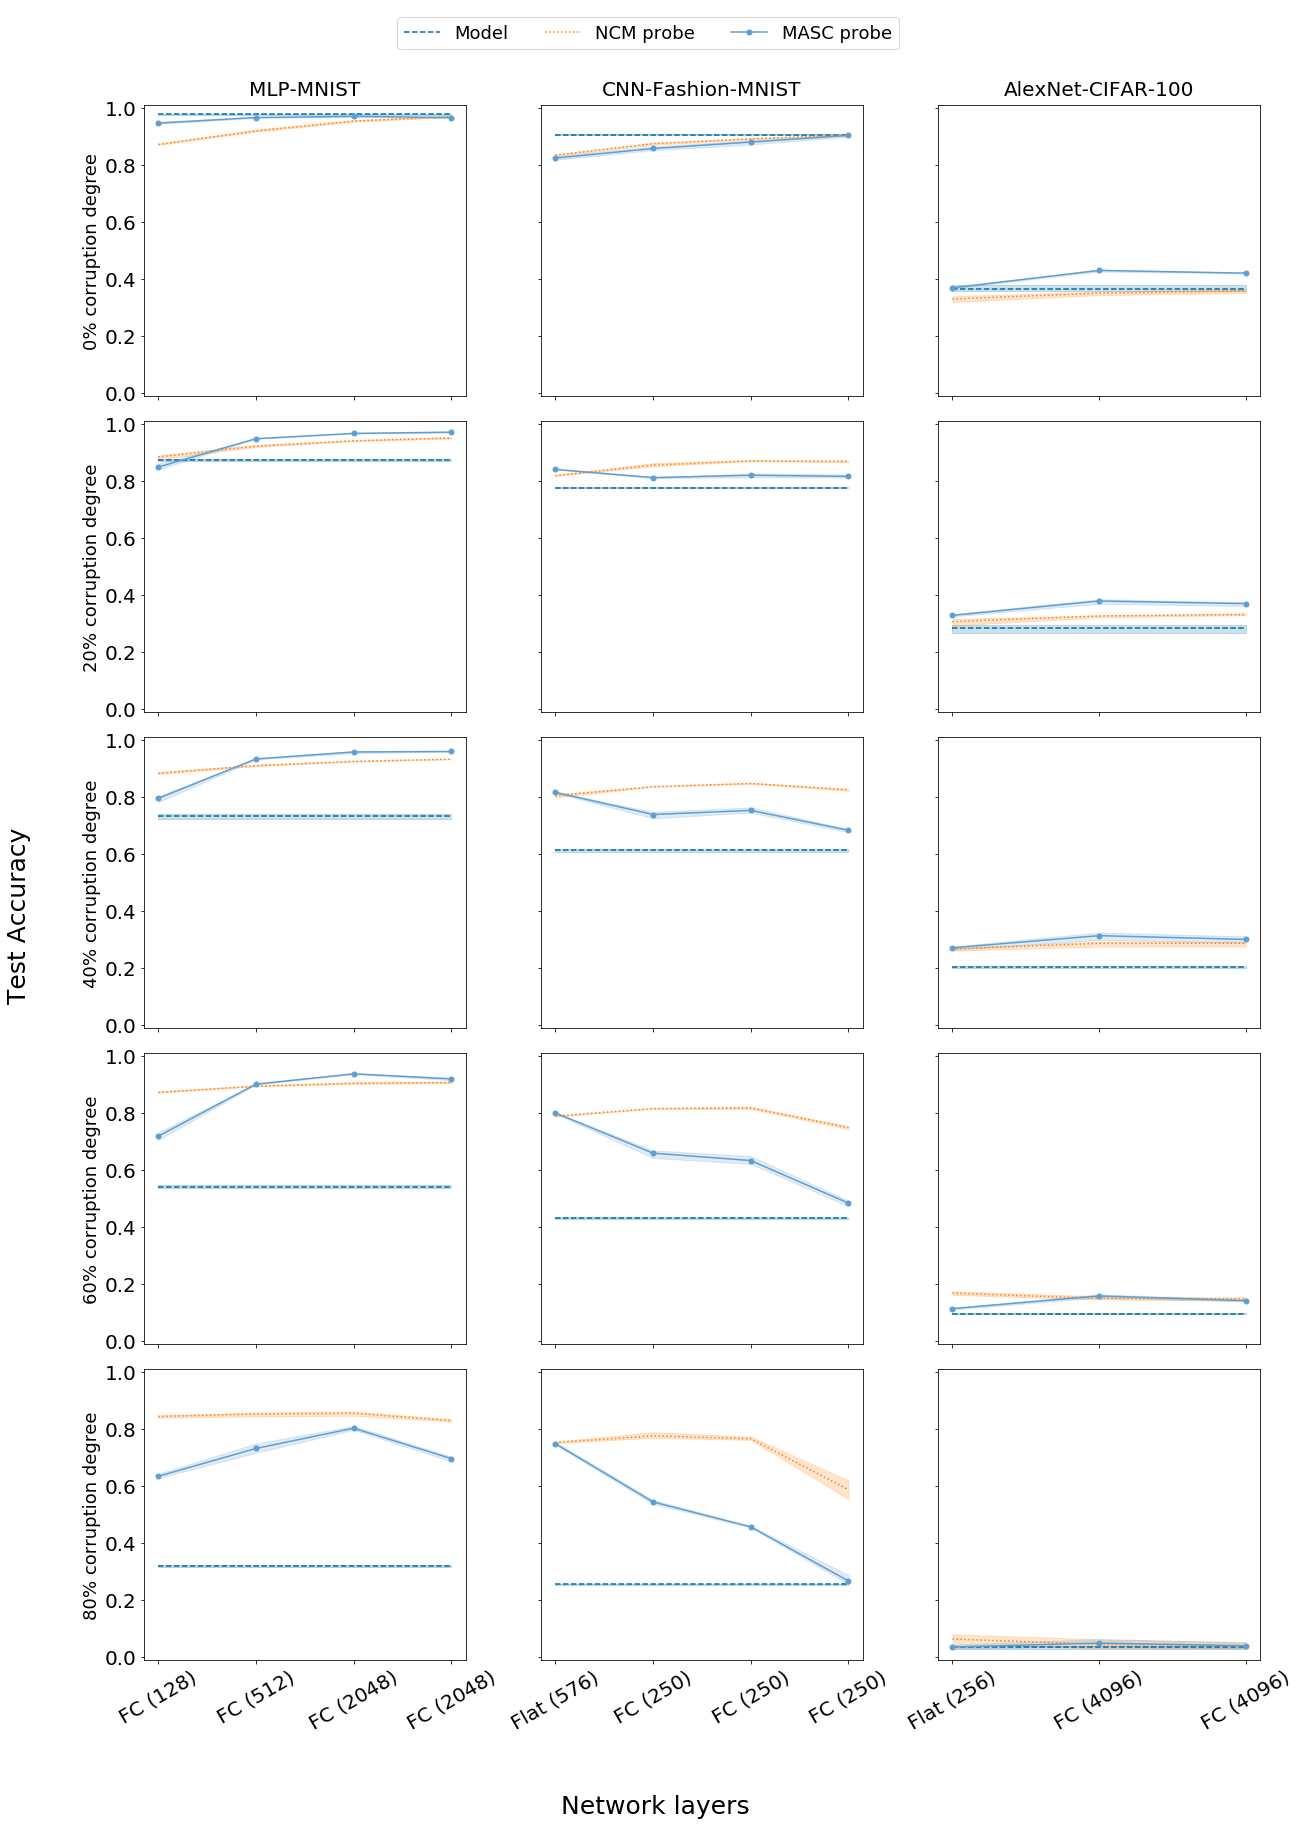

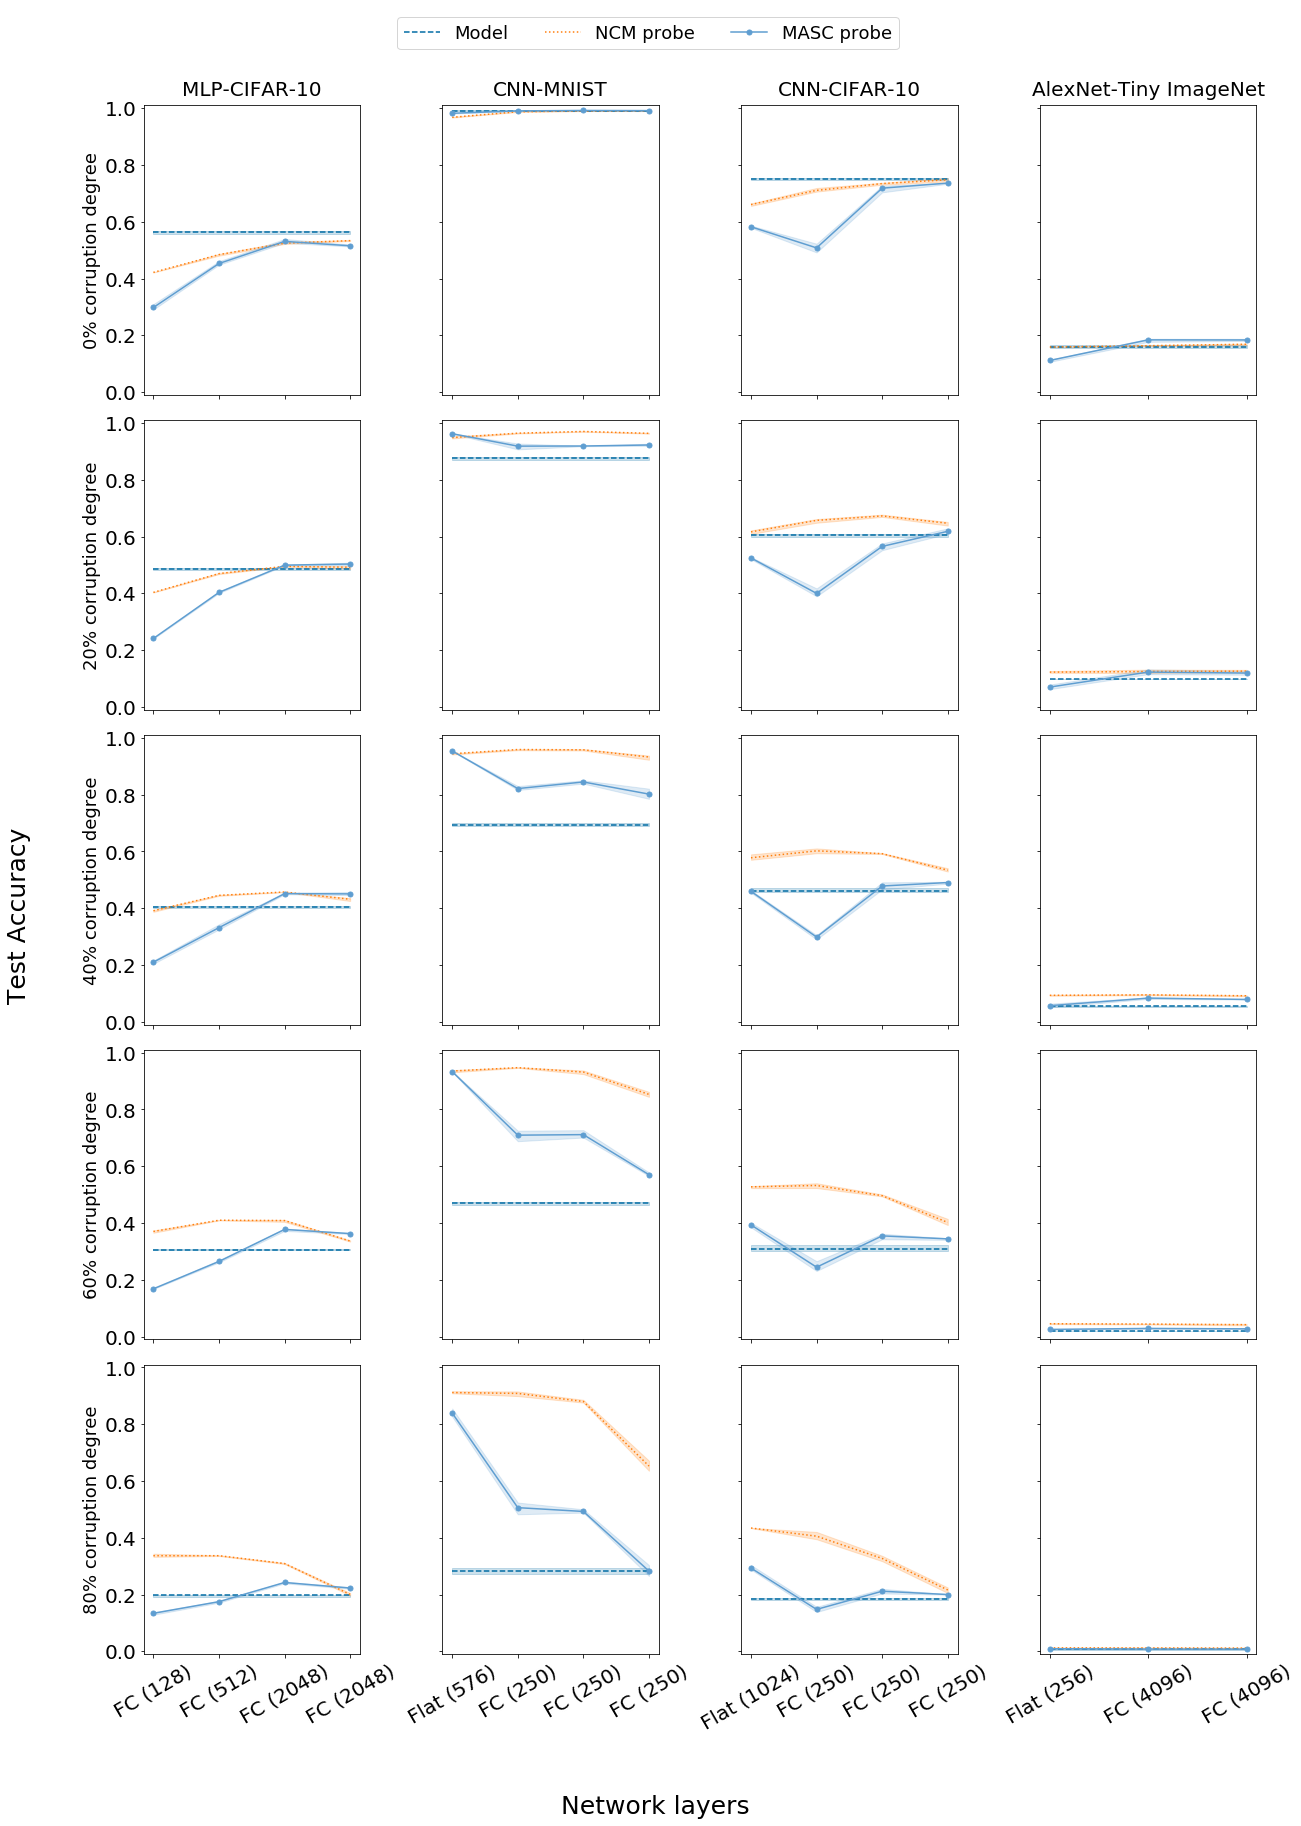

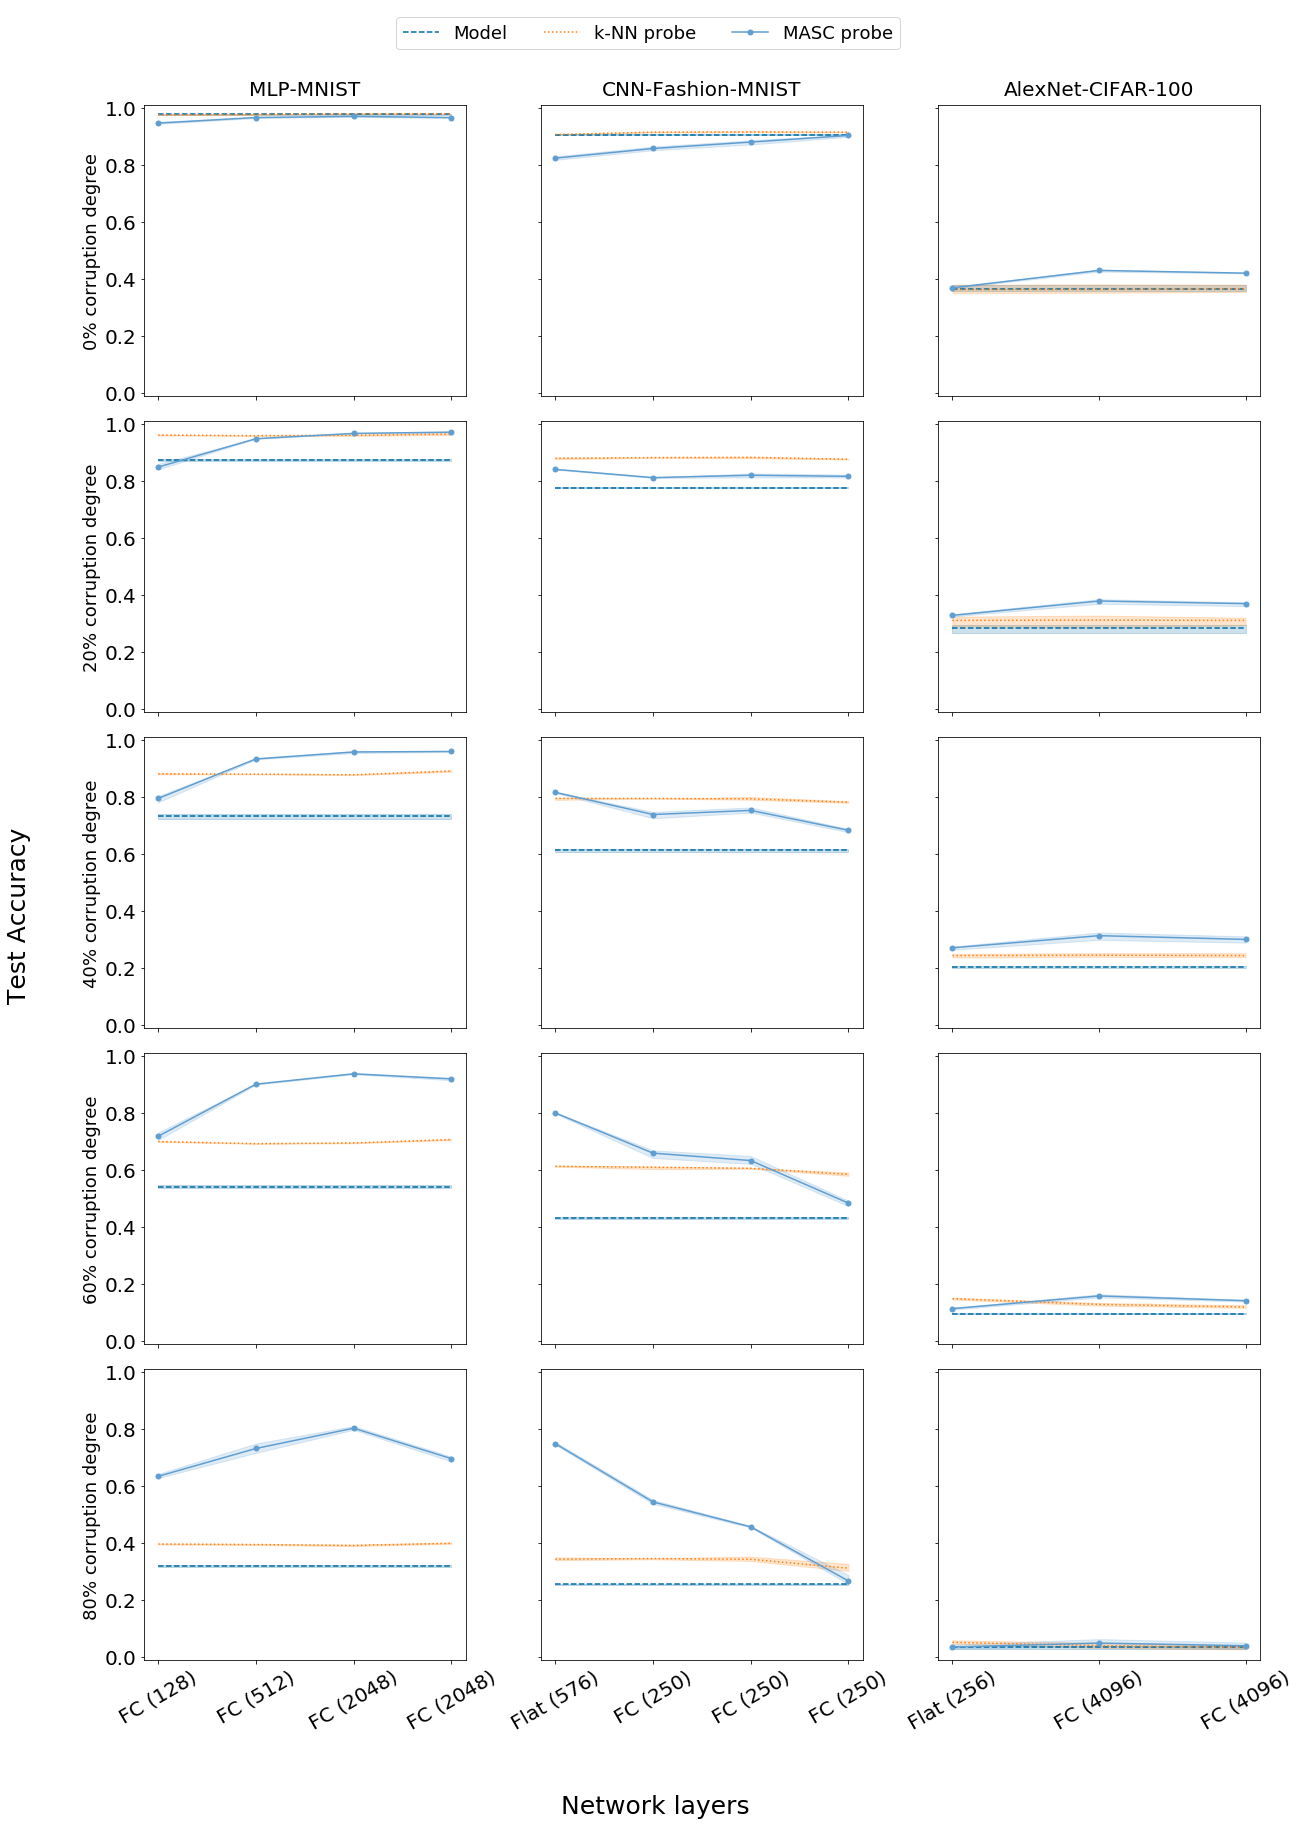

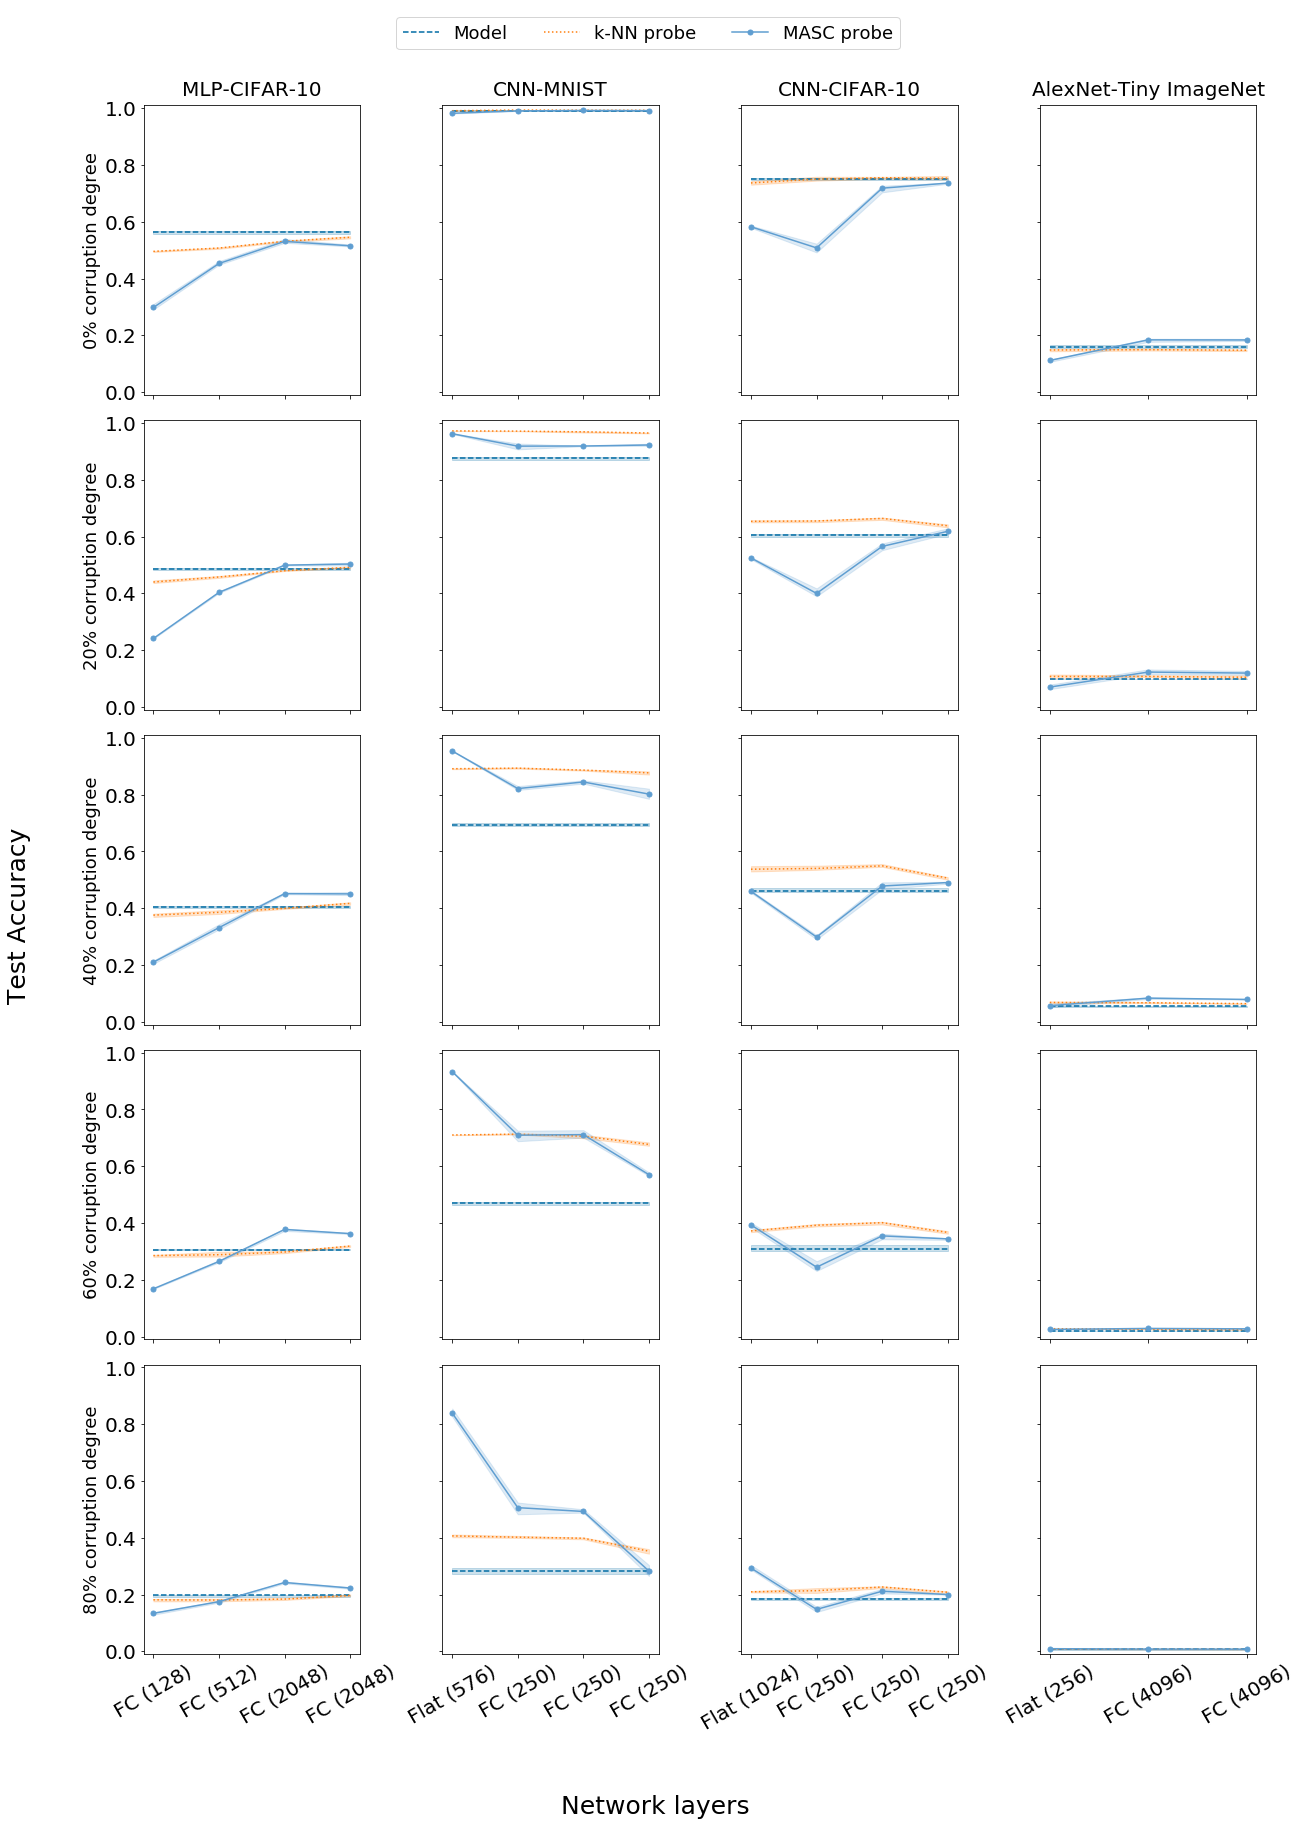

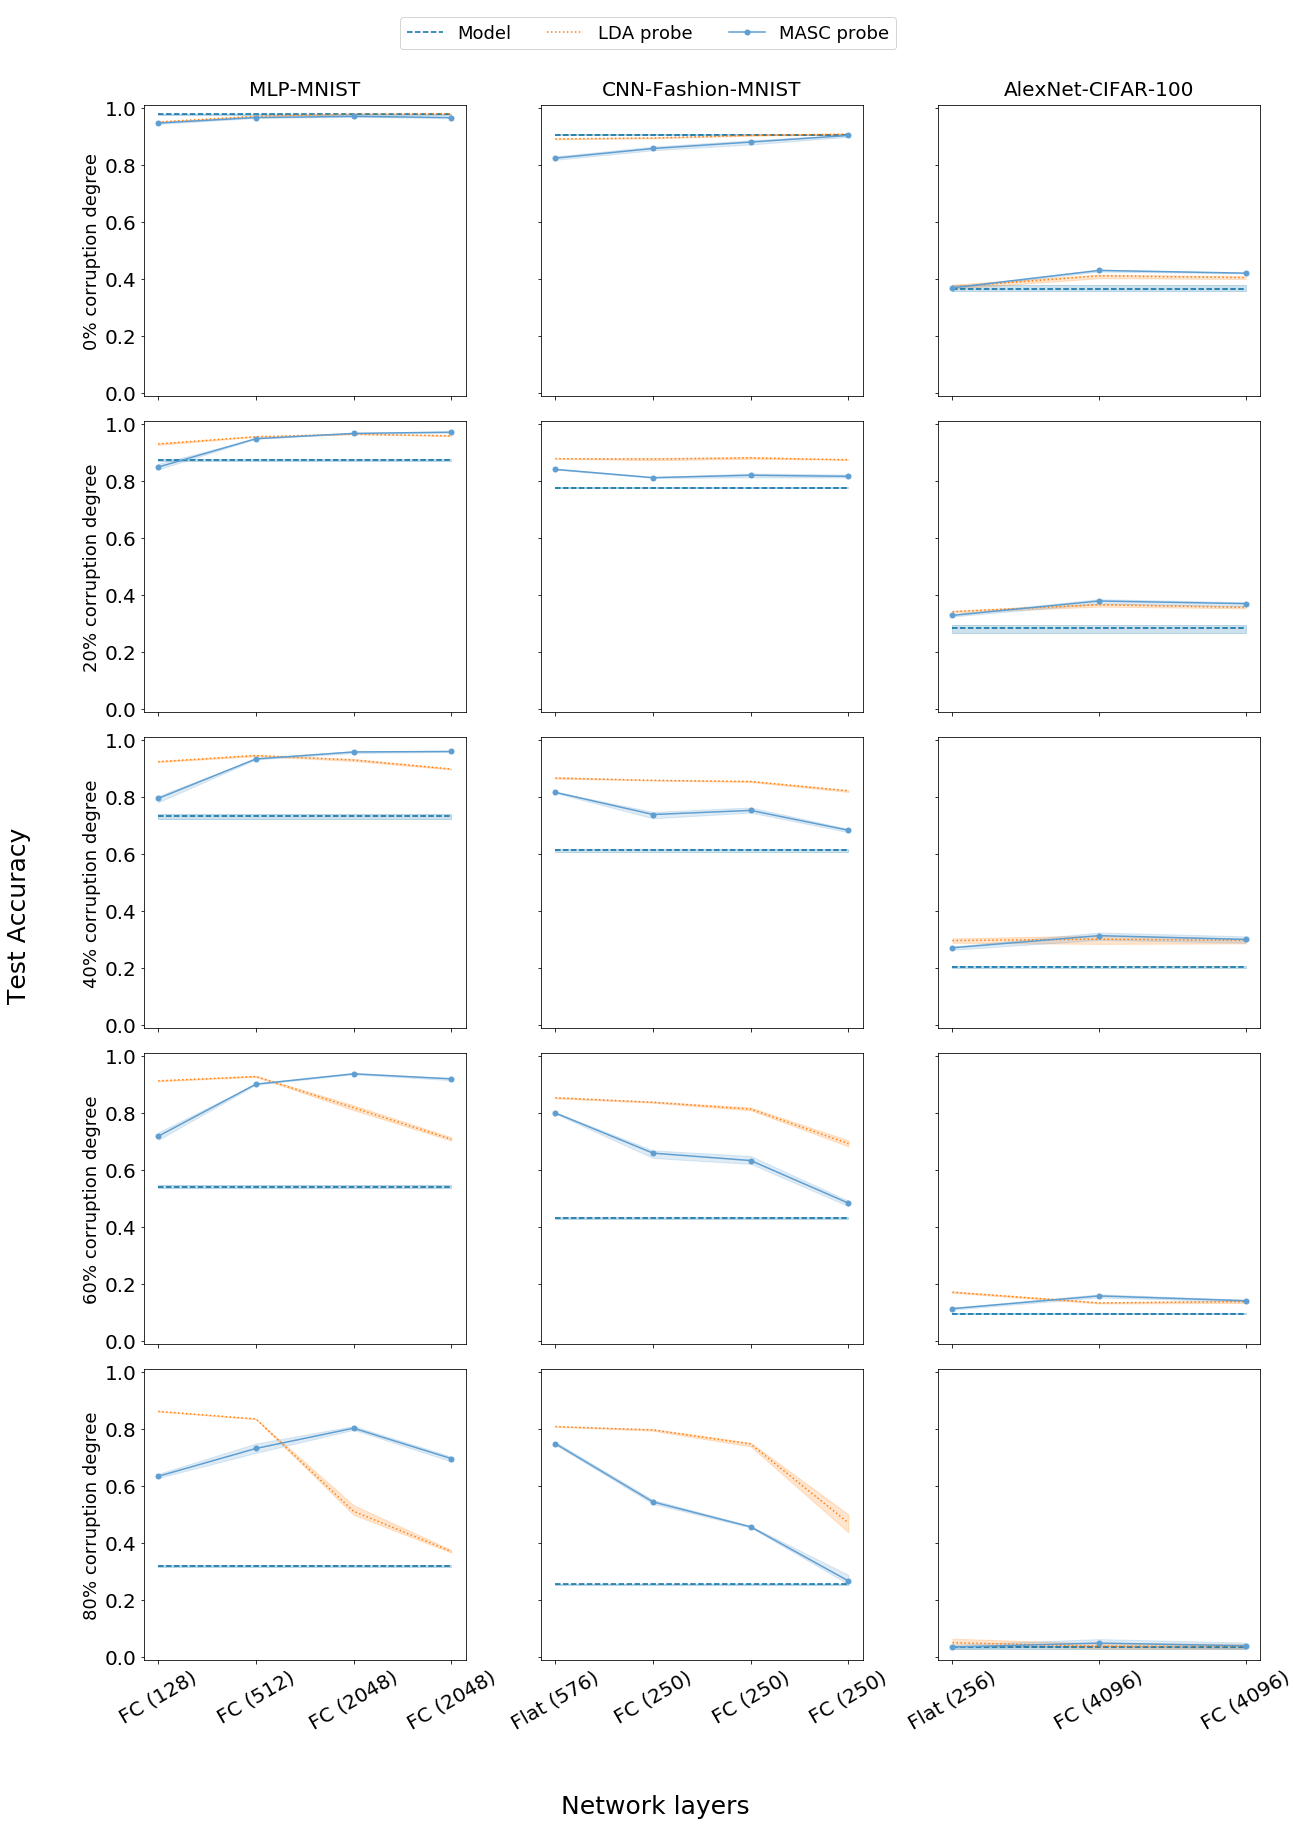

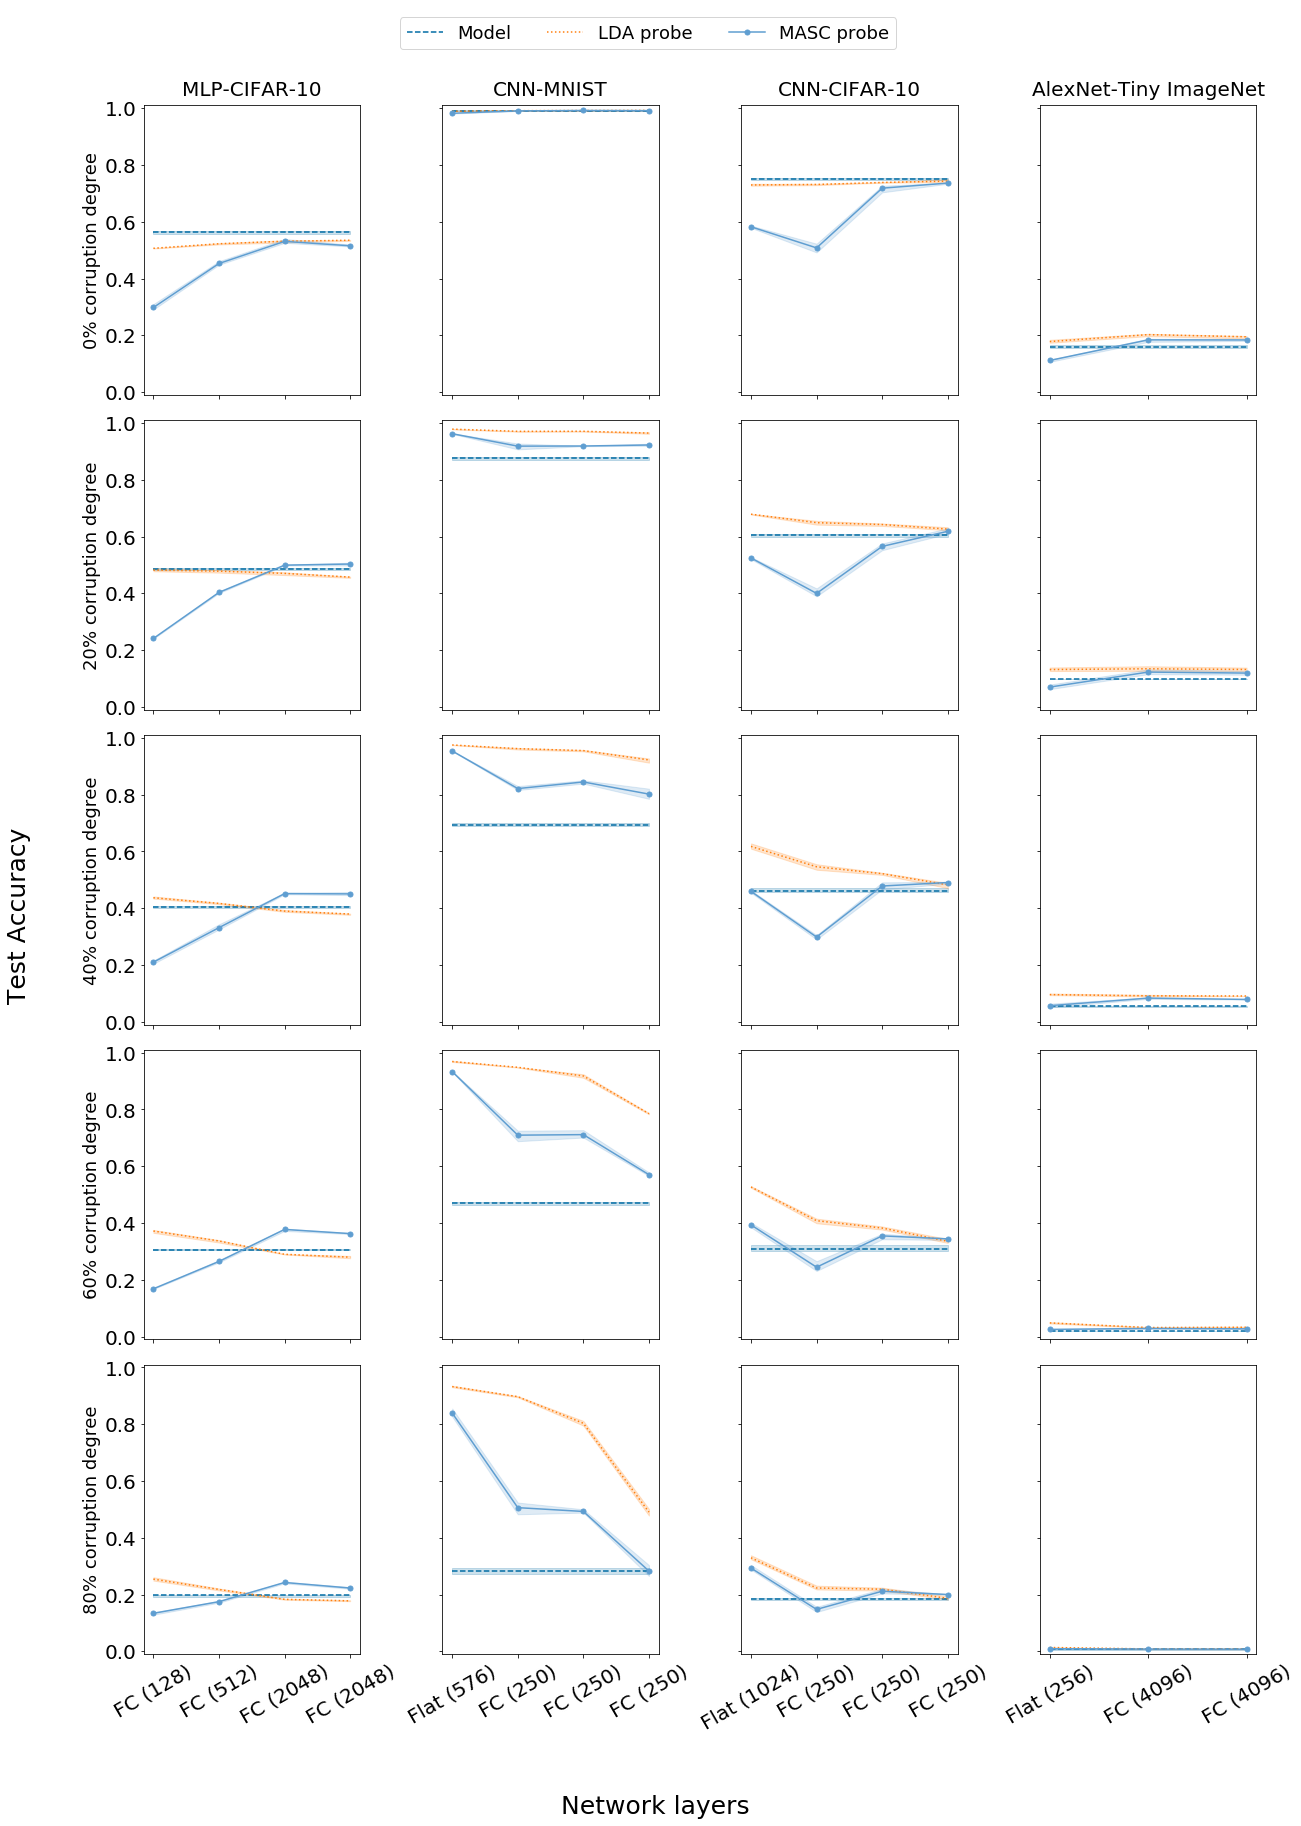

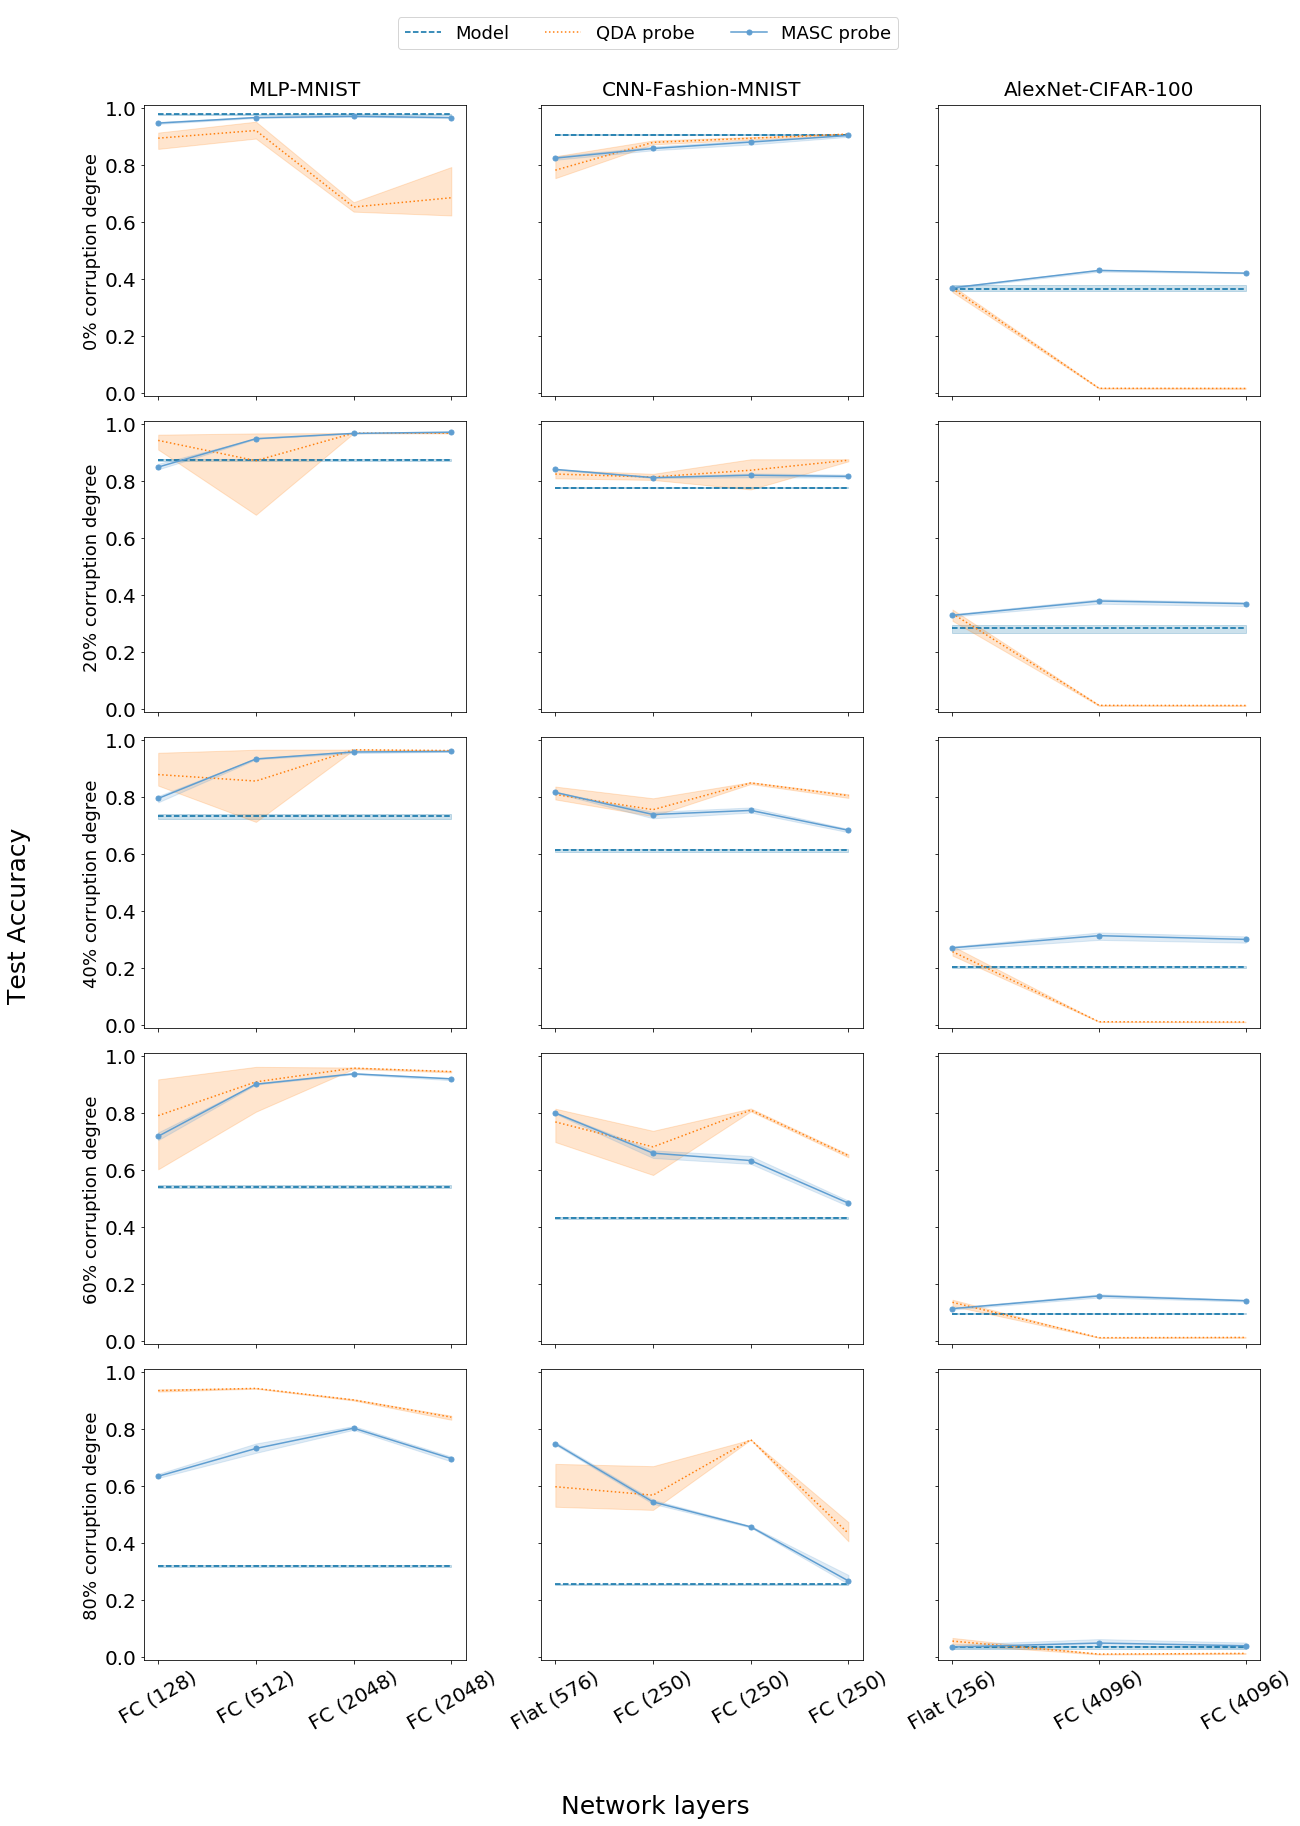

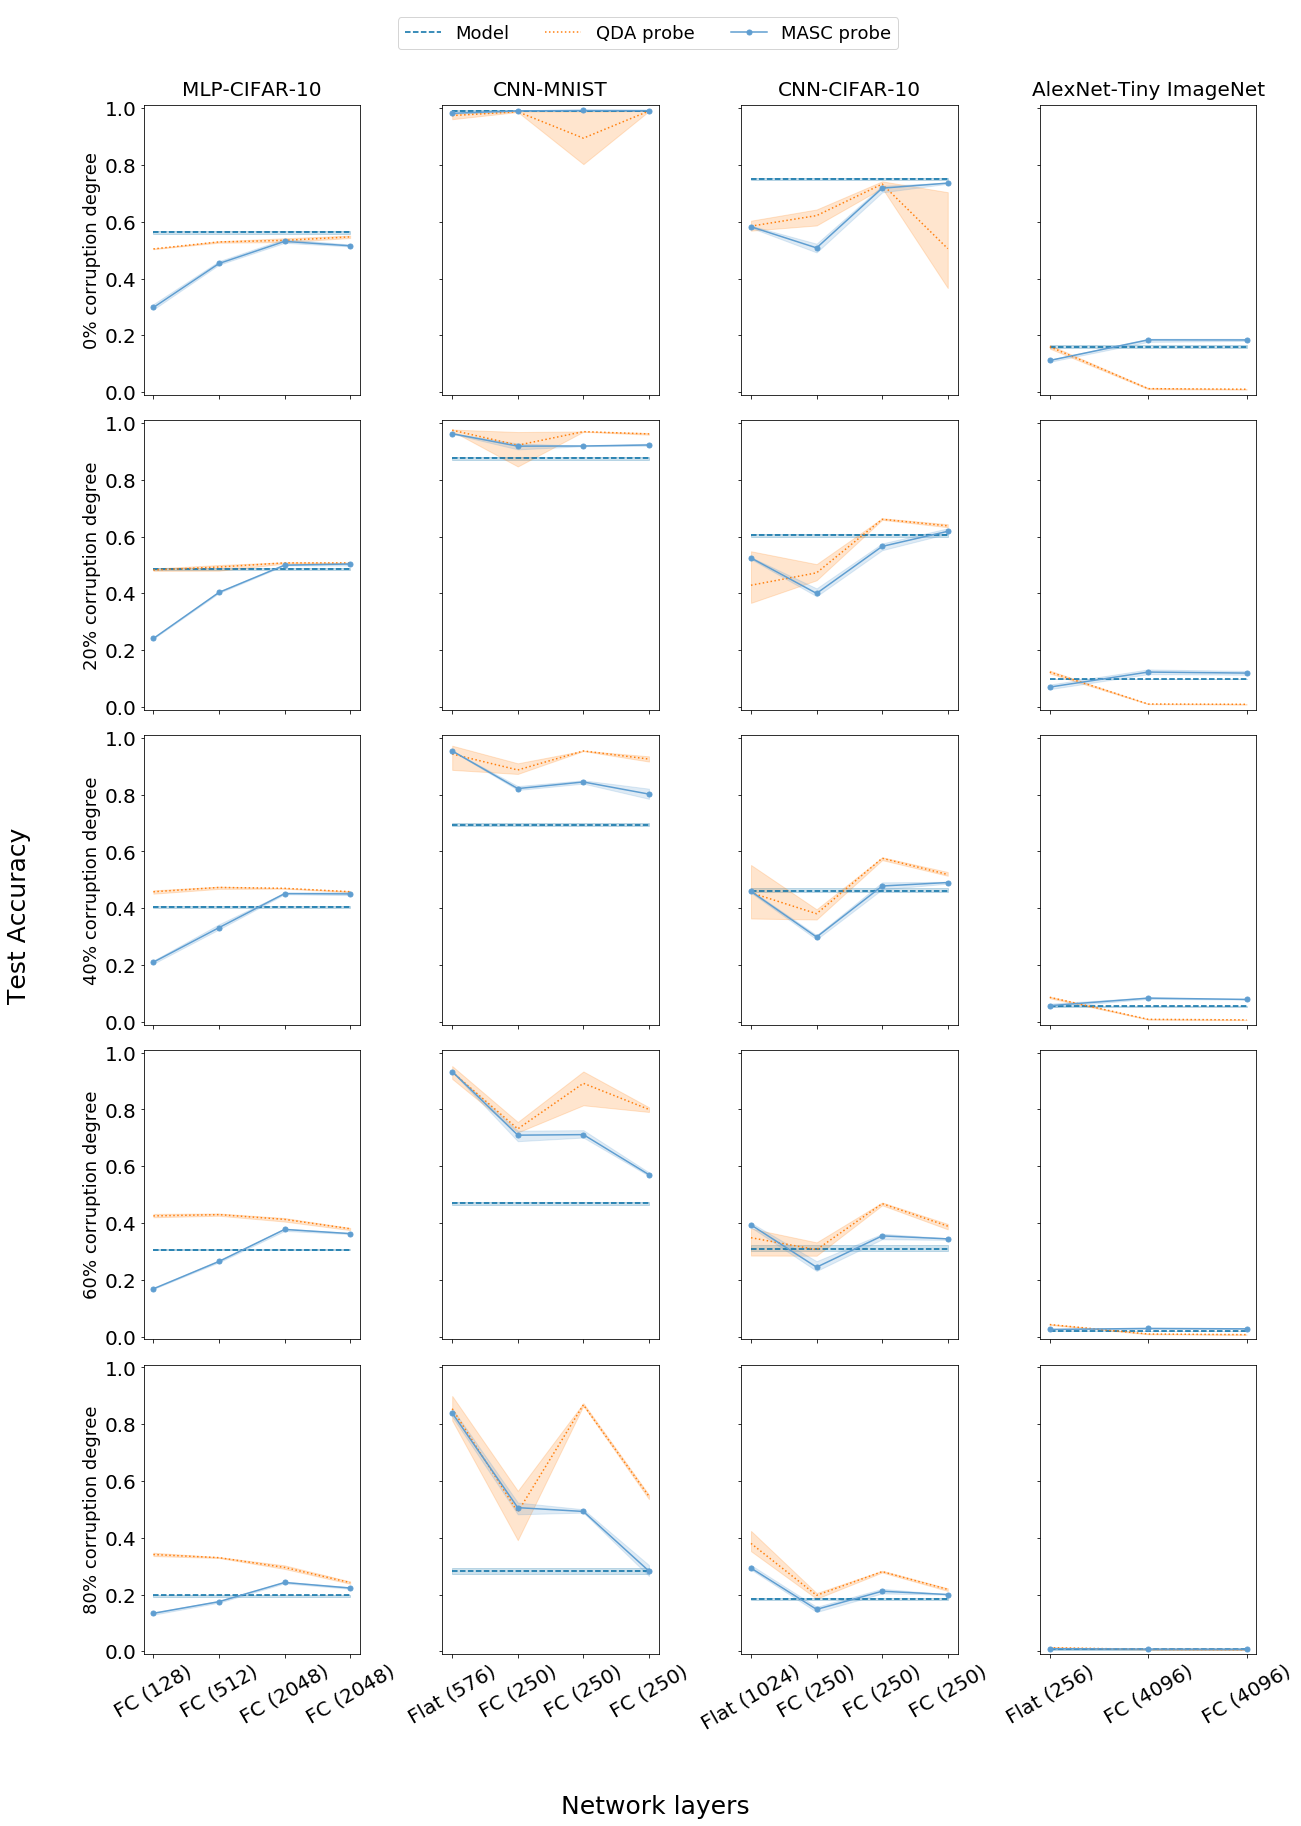

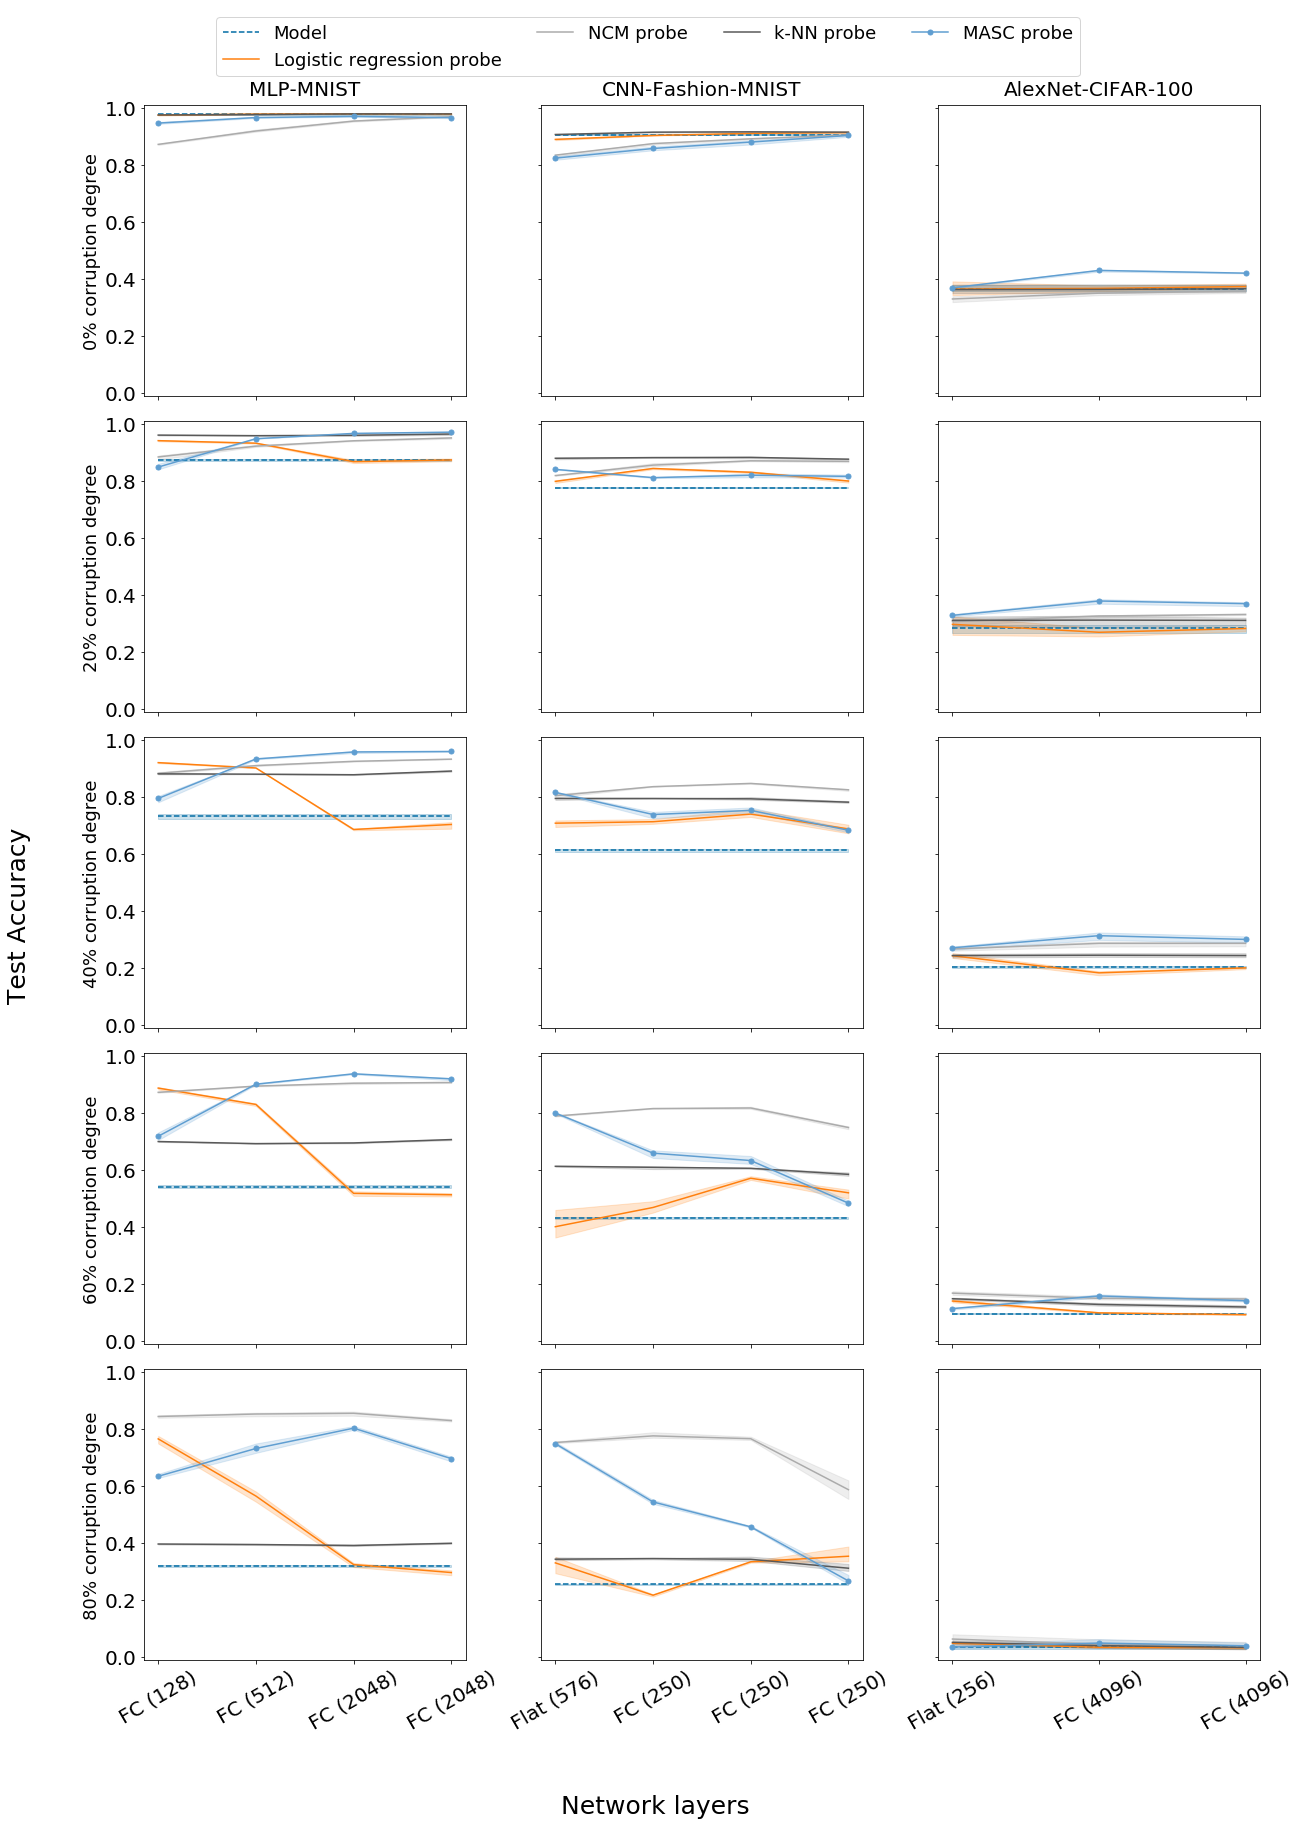

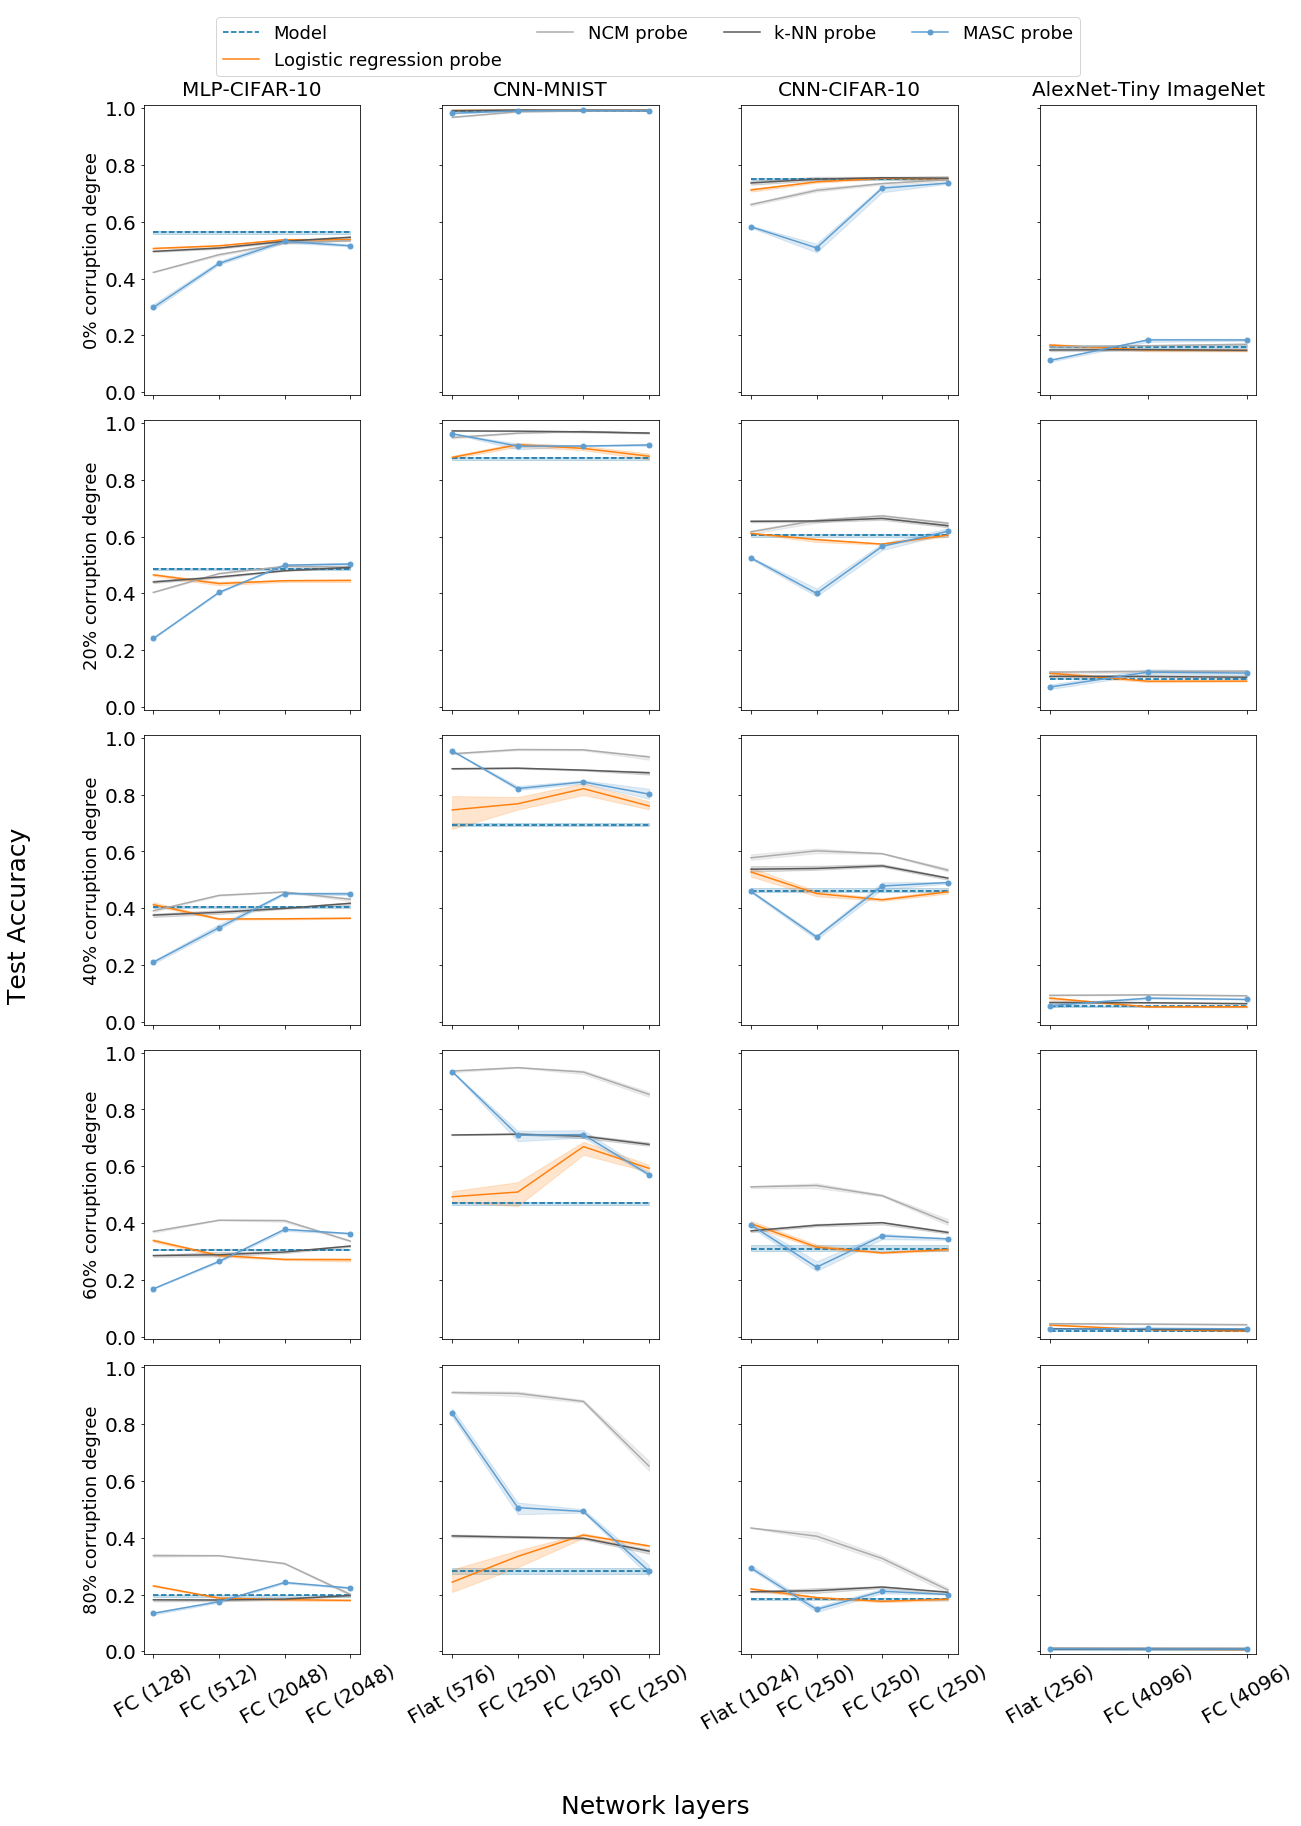

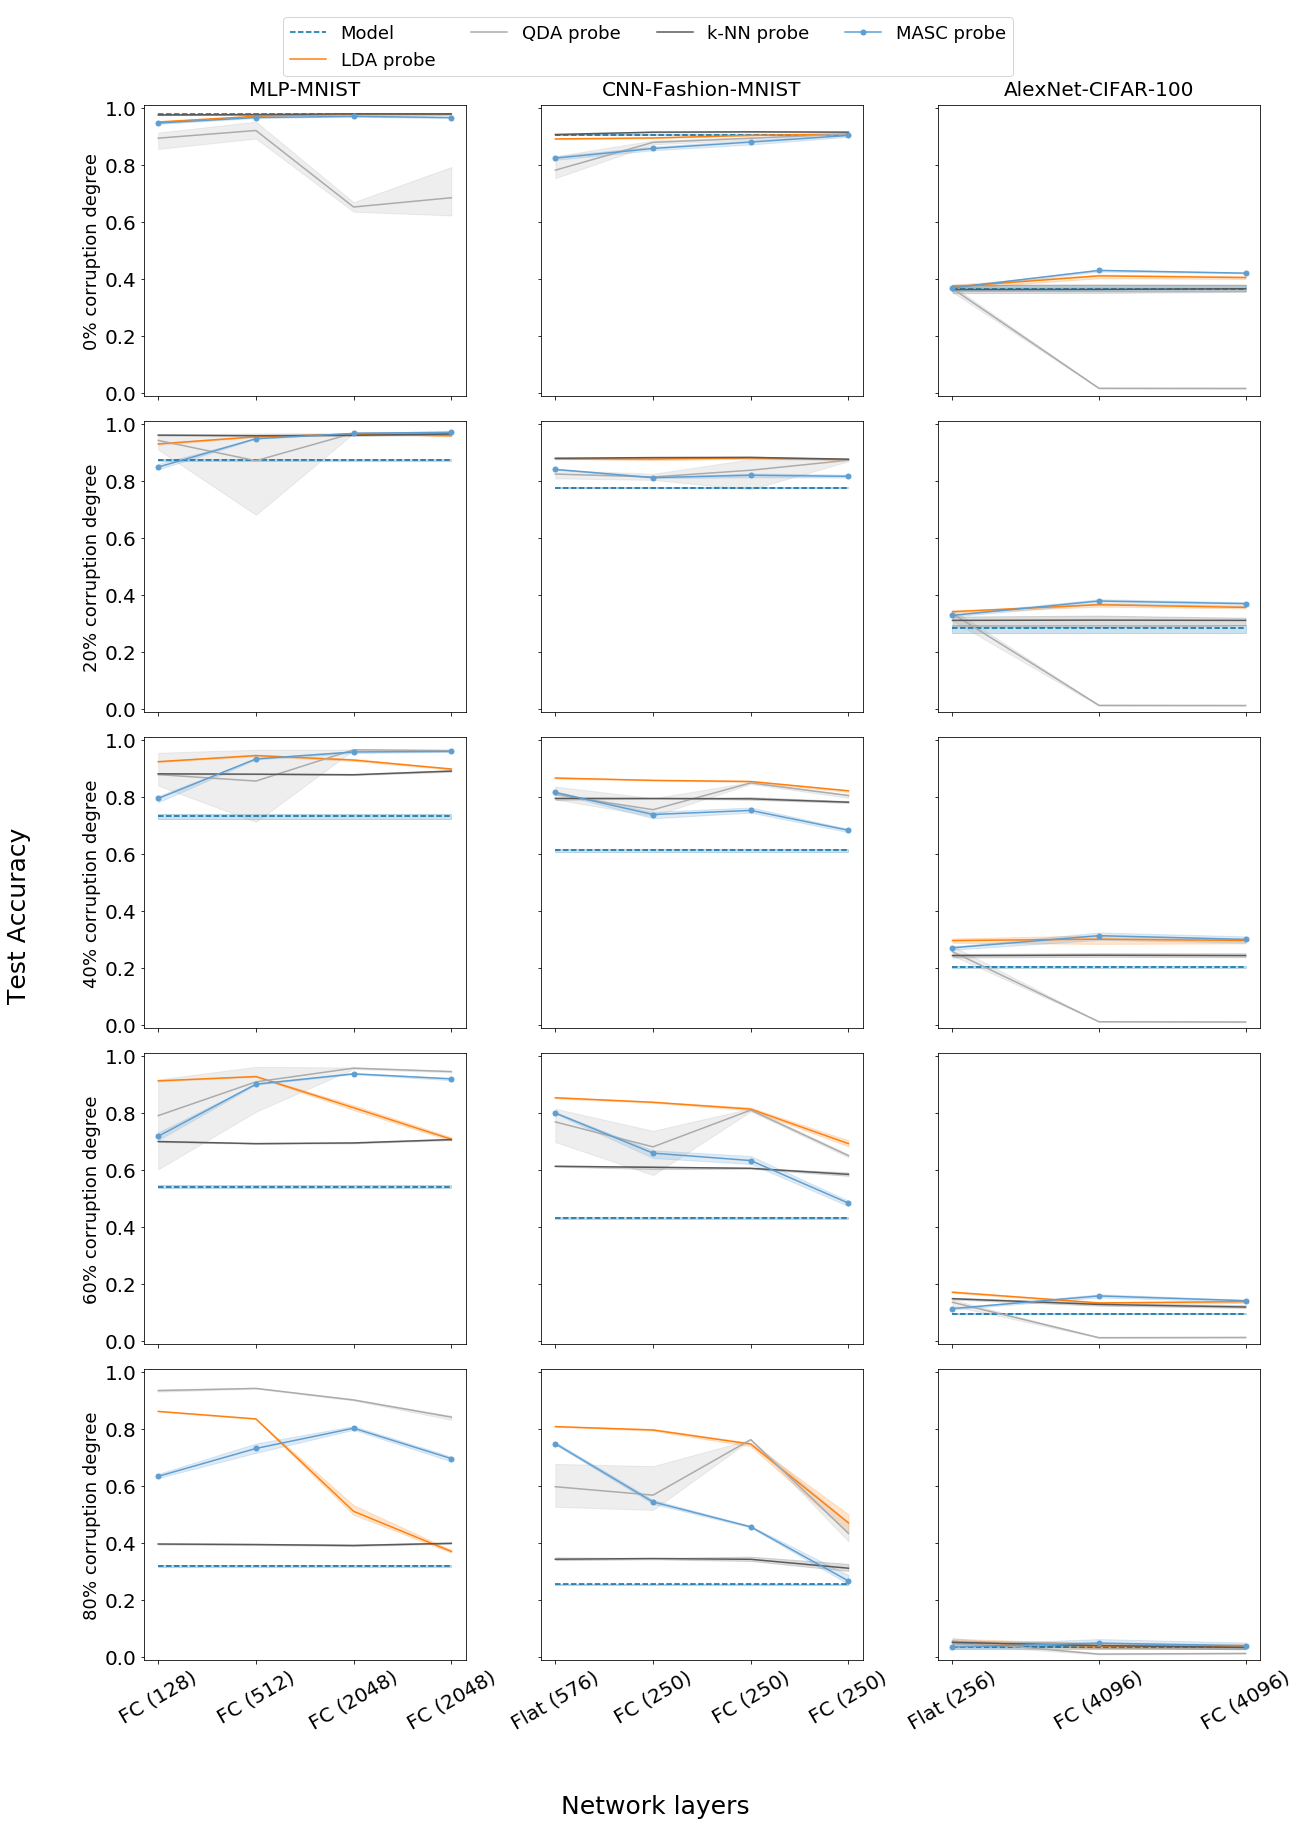

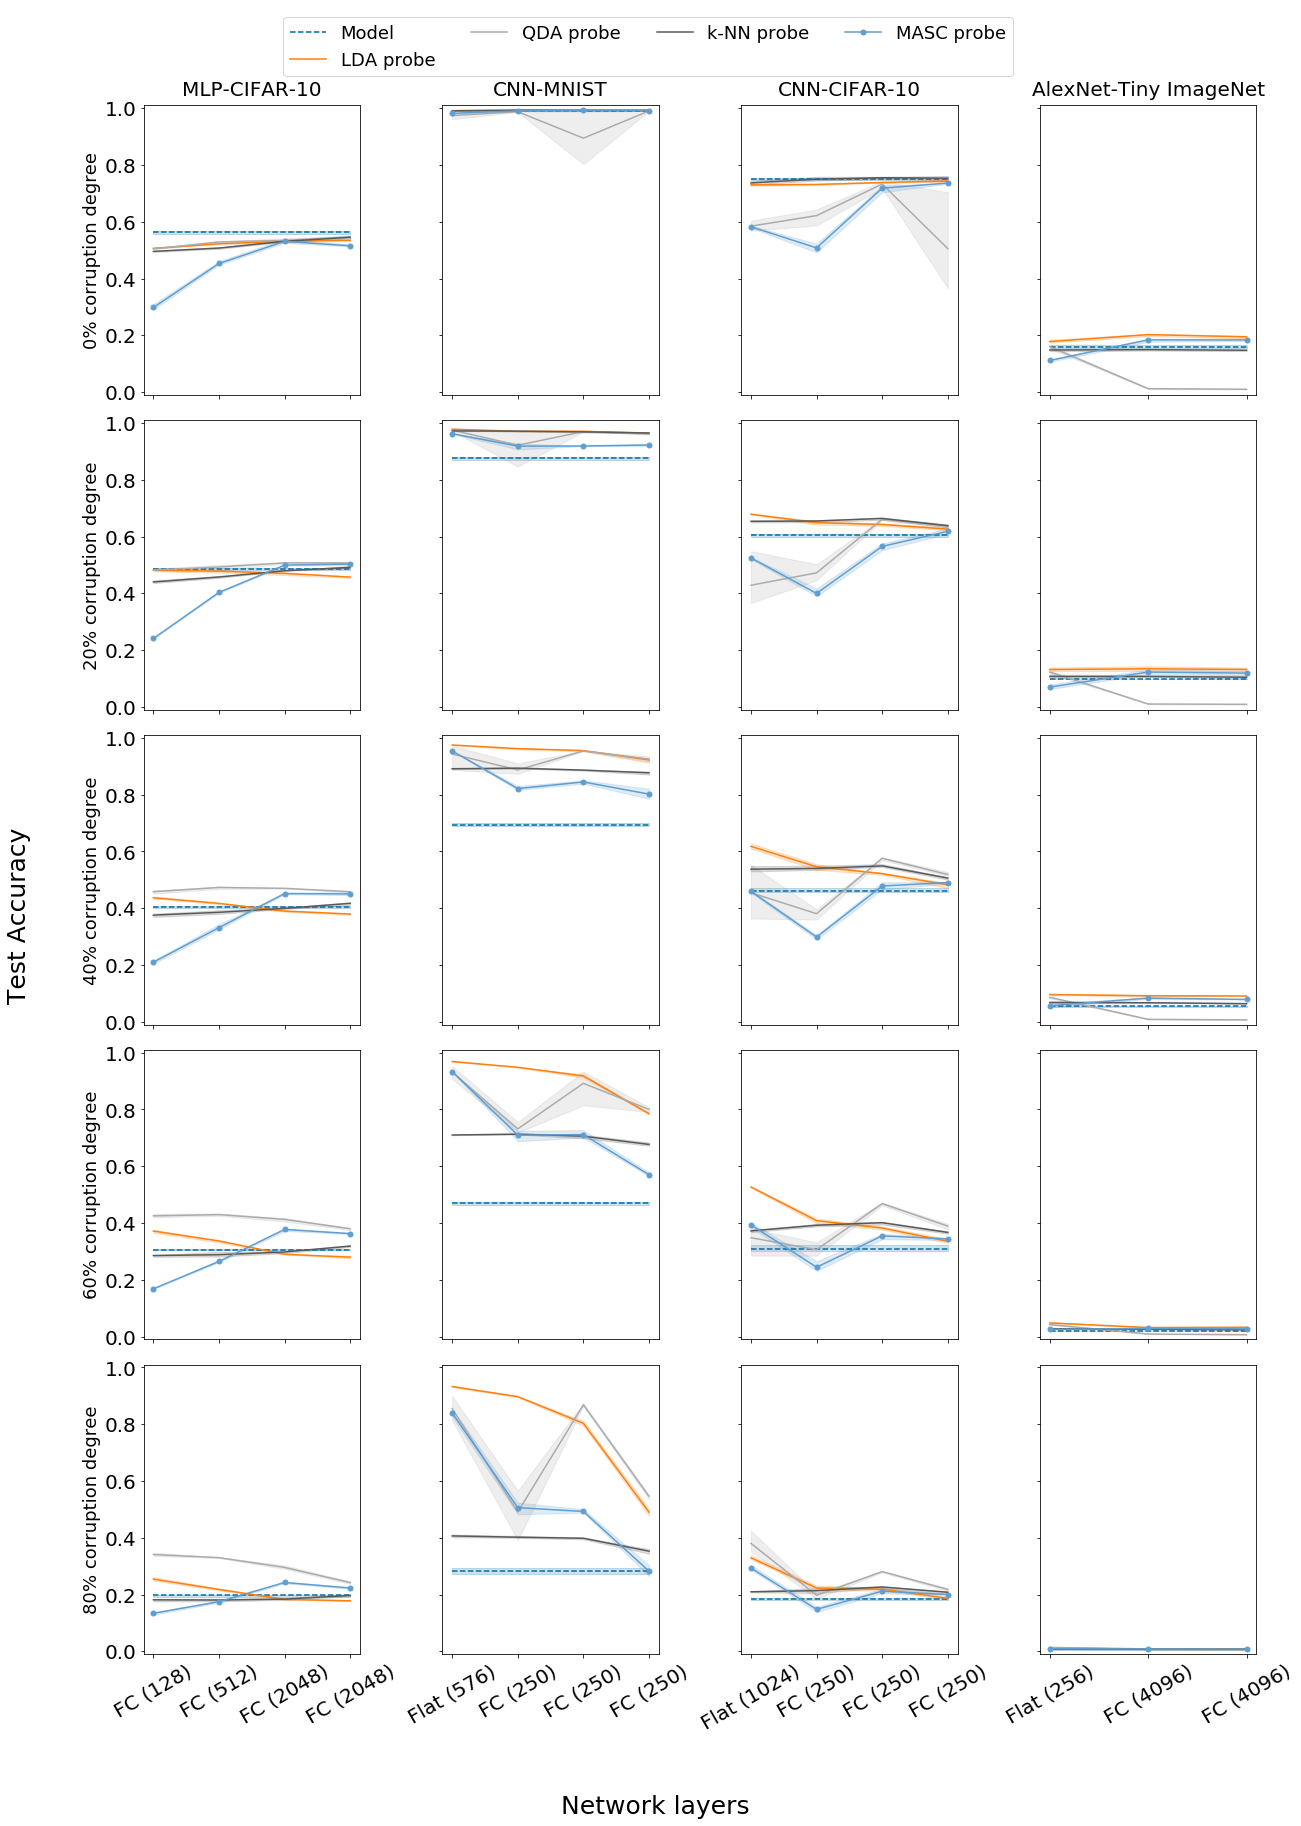

In [95]:
p1=plot_extra()
resfoldername='plots/stronger_baselines'
os.makedirs(f'{resfoldername}',exist_ok=True)
subspace='corrupt'
probes=['Logistic regression','NCM','k-NN', 'LDA','QDA']

for probe in probes:
    probe=[probe]
    p1.plot_accuracy_probewise(resfoldername,subspace,probe,other=False)
    p1.plot_accuracy_probewise(resfoldername,subspace,probe,other=True)
    
    
probes=['Logistic regression','NCM','k-NN']
p1.plot_accuracy_probewise2(resfoldername,subspace,probes,other=False)
p1.plot_accuracy_probewise2(resfoldername,subspace,probes,other=True)

probes=['LDA','QDA','k-NN']
p1.plot_accuracy_probewise2(resfoldername,subspace,probes,other=False)
p1.plot_accuracy_probewise2(resfoldername,subspace,probes,other=True)